# Prerequisites

In [40]:
!pip install --upgrade pip
!pip install -r requirements.txt

# Loading custom helpers

In [41]:
import requests  # Used for making HTTP requests to fetch online resources.

# URL of the raw file in the GitHub Gist
url = 'https://gist.githubusercontent.com/JMartinArocha/79e6f5c94ab6a8d3f0b2f57296395e76/raw/3d60d10fb336eb870cb03535929502bc8234abc9/ml_utilities.py'

# Fetching the content of the file
r = requests.get(url)

# Writing the content to a local file to ensure the utility script is available for import
with open('ml_utilities.py', 'w') as f:
    f.write(r.text)

# Importing the ml_utilities script after downloading it
import ml_utilities

# Loading dataset

In [42]:
import pandas as pd

source = 'https://raw.githubusercontent.com/JMartinArocha/ClusteringBankClients/main/data/bank.csv'

df = pd.read_csv(source, sep=';')
columns = df.columns.values
ml_utilities.df_look(df)

First few rows of the DataFrame:
   age          job  marital  education default  balance housing loan  \
0   30   unemployed  married    primary      no     1787      no   no   
1   33     services  married  secondary      no     4789     yes  yes   
2   35   management   single   tertiary      no     1350     yes   no   
3   30   management  married   tertiary      no     1476     yes  yes   
4   59  blue-collar  married  secondary      no        0     yes   no   

    contact  day month  duration  campaign  pdays  previous poutcome   y  
0  cellular   19   oct        79         1     -1         0  unknown  no  
1  cellular   11   may       220         1    339         4  failure  no  
2  cellular   16   apr       185         1    330         1  failure  no  
3   unknown    3   jun       199         4     -1         0  unknown  no  
4   unknown    5   may       226         1     -1         0  unknown  no  

Data types of the columns:
age           int64
job          object
marital   

# Data clean and normalization

In [43]:
from sklearn.decomposition import PCA
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import MinMaxScaler, LabelEncoder, OneHotEncoder, OrdinalEncoder
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt

columns_selected = ['age', 'job', 'marital', 'education', 'balance', 'housing', 'loan', 'contact',  'duration','campaign', 'poutcome', 'y']
categorical_features = ['job', 'marital', 'education', 'housing', 'loan', 'contact', 'poutcome', 'y']
numeric_features = ['age', 'balance', 'duration', 'campaign',]

df = df[columns_selected]


## Alternative label encoding

In [44]:
# from sklearn.preprocessing import OneHotEncoder

# onehot_encoder = OneHotEncoder(sparse_output=False)  # Use sparse=False para obtener una matriz densa
# encoded_features = onehot_encoder.fit_transform(df[categorical_features])
# # Crear un nuevo DataFrame con las columnas codificadas y concatenarlo con el original (excluyendo las categóricas originales)
# df_encoded = pd.DataFrame(encoded_features, columns=onehot_encoder.get_feature_names_out(categorical_features))
# df = df.drop(columns=categorical_features).join(df_encoded)


In [45]:
# from sklearn.preprocessing import OrdinalEncoder

# ordinal_encoder = OrdinalEncoder()
# df[categorical_features] = ordinal_encoder.fit_transform(df[categorical_features])


In [46]:
# Initialize the label encoder
label_encoder = LabelEncoder()

# Apply the label encoder to each categorical column using a loop
for column in categorical_features:
    df[column] = label_encoder.fit_transform(df[column])

# Scaling the data

In [47]:
min_max_scaler = MinMaxScaler()

# Escalar todas las columnas excepto la variable objetivo
# transformed_data = min_max_scaler.fit_transform(df.drop(columns='y'))
transformed_data = min_max_scaler.fit_transform(df)

# Convertir el array transformado de vuelta a un DataFrame
transformed_df = pd.DataFrame(transformed_data, columns=df.columns)

# Añadir la variable objetivo de vuelta al DataFrame
# transformed_df['y'] = df['y']


# PCA

In [48]:
import matplotlib.pyplot as plt
import numpy as np

# Define the number of components or the variance ratio to keep
pca = PCA(n_components=6)
X_pca = pca.fit_transform(transformed_data)

# Mostramos el porcentaje de varianza explicada por cada uno de los componentes seleccionados.
print(pca.explained_variance_ratio_)

# Visualizar la "importancia" de cada variable original del problema en las nuevas dimensiones
pd.DataFrame(np.matrix.transpose(pca.components_), index=df.columns)

[0.26445274 0.18531217 0.12481589 0.09489372 0.08979668 0.08210976]


0         1         2         3         4         5
age        0.040490 -0.055506  0.019778  0.187935 -0.116498 -0.013950
job        0.114728 -0.022419 -0.103584 -0.398784  0.287579 -0.036371
marital    0.050828  0.061621 -0.130633 -0.595971  0.447077  0.230127
education  0.081631  0.036904 -0.087546 -0.221447  0.164286  0.014000
balance    0.003900 -0.001125 -0.008343  0.000061 -0.000451  0.004843
housing   -0.806814  0.537082 -0.035950 -0.062903  0.065943 -0.202778
loan      -0.029657  0.002243  0.949449  0.005504  0.300127  0.069904
contact   -0.547678 -0.715328 -0.106852  0.110027  0.194800  0.347809
duration   0.004461  0.008826 -0.019327  0.065634  0.090076 -0.035733
campaign  -0.001596 -0.007281  0.005893 -0.013444 -0.008037 -0.017551
poutcome  -0.064045 -0.427425  0.069648 -0.249997 -0.005019 -0.849119
y          0.141534  0.090980 -0.211326  0.564226  0.732313 -0.236093

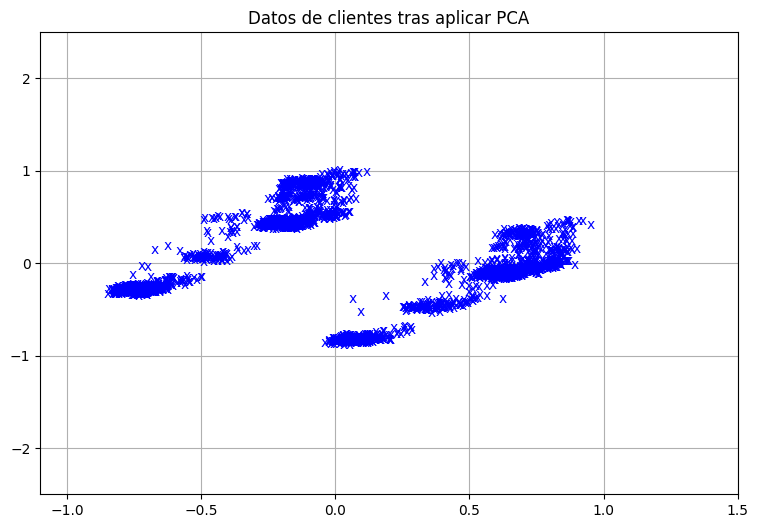

In [49]:
plt.figure(figsize=(9, 6))
for i in range(len(X_pca)):
    plt.text(X_pca[i][0], X_pca[i][1], 'x', color="b")
plt.xlim(-1.1, 1.5)
plt.ylim(-2.5, 2.5)
plt.title("Datos de clientes tras aplicar PCA")
plt.grid()
plt.show()

# Kmeans

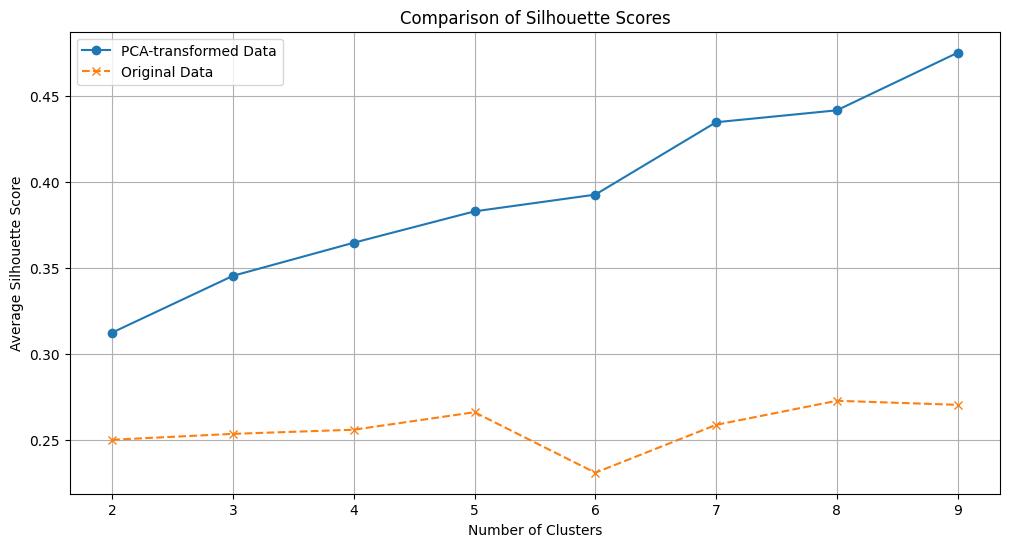

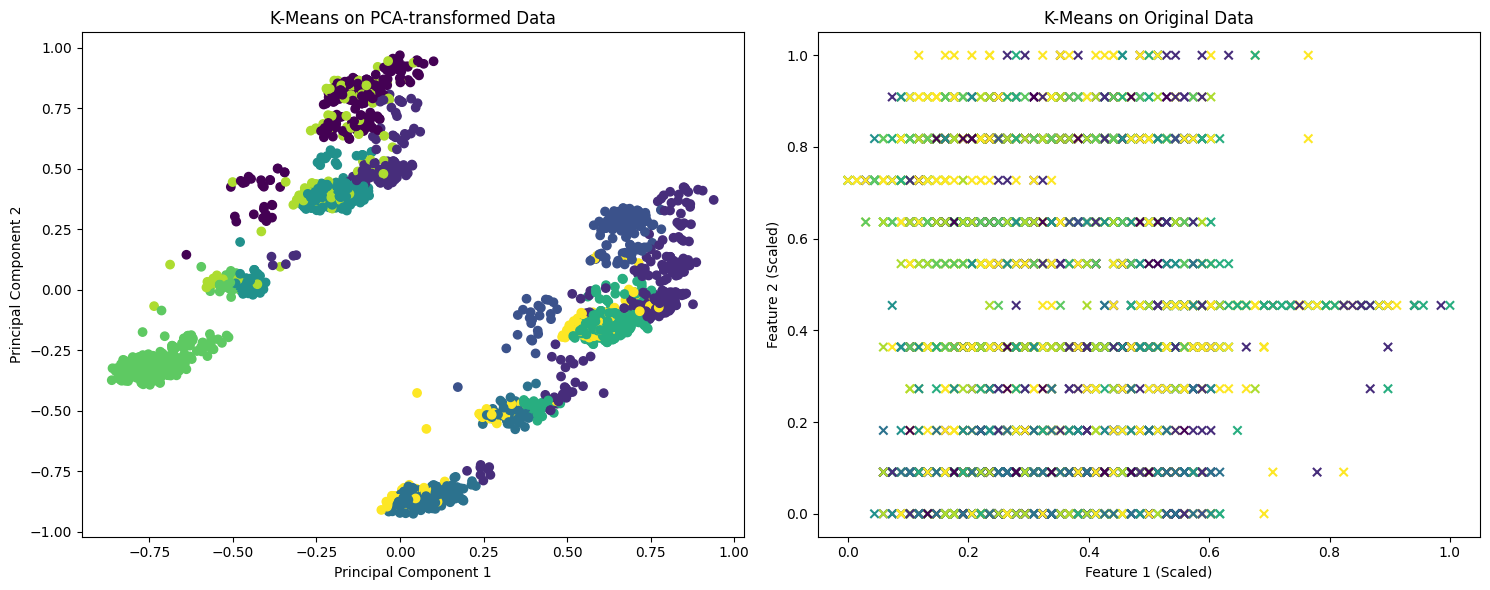

In [50]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import numpy as np

# Transformed_data is your preprocessed data ready for clustering
# and X_pca is the PCA-transformed data

# Define the range of clusters to evaluate
range_n_clusters = list(range(2, 10))
silhouette_avg_pca = []
silhouette_avg_original = []

for n_clusters in range_n_clusters:
    # Configure KMeans
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    
    # Clustering on PCA-transformed data
    cluster_labels_pca = clusterer.fit_predict(X_pca)
    silhouette_avg_pca.append(silhouette_score(X_pca, cluster_labels_pca))
    
    # Clustering on original data
    cluster_labels_original = clusterer.fit_predict(transformed_data)
    silhouette_avg_original.append(silhouette_score(transformed_data, cluster_labels_original))

# Plotting the silhouette scores
plt.figure(figsize=(12, 6))
plt.plot(range_n_clusters, silhouette_avg_pca, marker='o', linestyle='-', label='PCA-transformed Data')
plt.plot(range_n_clusters, silhouette_avg_original, marker='x', linestyle='--', label='Original Data')
plt.title('Comparison of Silhouette Scores')
plt.xlabel('Number of Clusters')
plt.ylabel('Average Silhouette Score')
plt.legend()
plt.grid(True)
plt.show()
fig, ax = plt.subplots(1, 2, figsize=(15, 6))

# Visualization on PCA-transformed data
ax[0].scatter(X_pca[:, 0], X_pca[:, 1], c=cluster_labels_pca, cmap='viridis', marker='o')
ax[0].set_title("K-Means on PCA-transformed Data")
ax[0].set_xlabel("Principal Component 1")
ax[0].set_ylabel("Principal Component 2")

# Visualization on original data (if it's 2D or has been reduced for visualization)
ax[1].scatter(transformed_data[:, 0], transformed_data[:, 1], c=cluster_labels_original, cmap='viridis', marker='x')
ax[1].set_title("K-Means on Original Data")
ax[1].set_xlabel("Feature 1 (Scaled)")
ax[1].set_ylabel("Feature 2 (Scaled)")

plt.tight_layout()
plt.show()

## Dendrogram Analysis

Average Distance after PCA	   1.26
Inconsistency Coefficients for the last 10 cluster merges using single:
[[ 0.33958933  0.17544544 13.          1.27789953]
 [ 0.43780478  0.09017717  6.          1.42373271]
 [ 0.36345759  0.20273695  9.          1.06036189]
 [ 0.27497783  0.19794699 23.          3.022319  ]
 [ 0.3805548   0.21558474 21.          2.48745052]
 [ 0.46278834  0.18351505 15.          2.51534948]
 [ 0.43000234  0.23773034 21.          2.08719066]
 [ 0.50270153  0.20447186 17.          2.15232568]
 [ 0.50141011  0.23920803 21.          1.852308  ]
 [ 0.54565561  0.2704639  27.          1.50068873]]
Unique clusters identified at cut depth using single:
[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15]


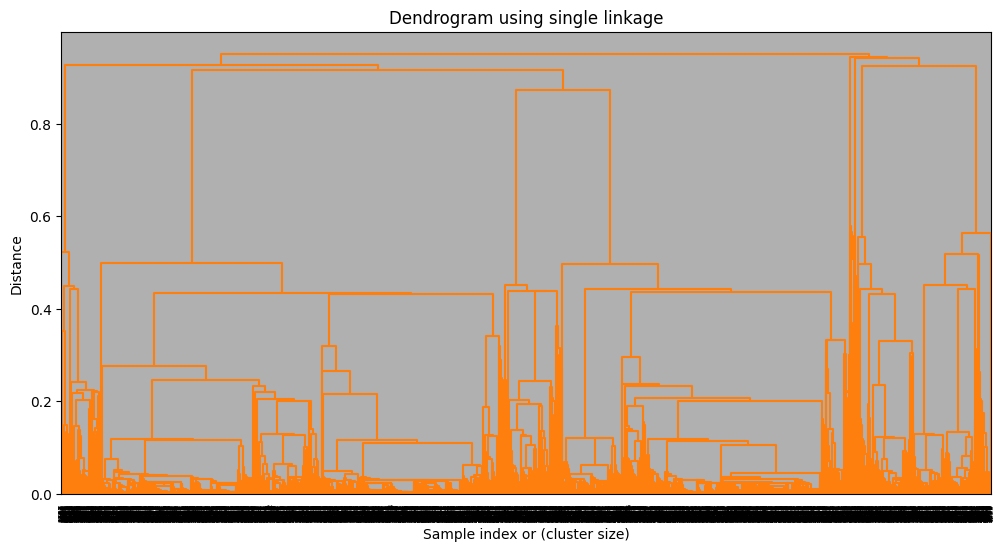

Silhouette Score for 2 clusters using single linkage: 0.2557862578723178


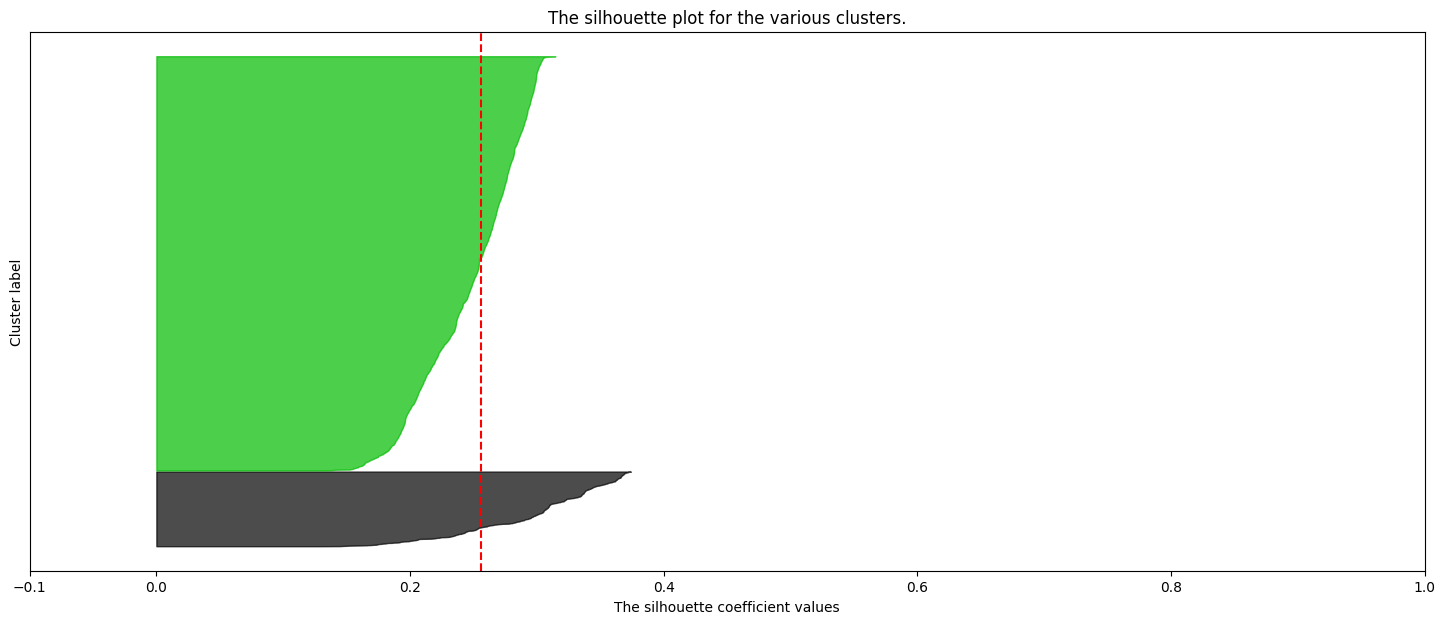

Silhouette Score for 3 clusters using single linkage: 0.22905505173071775


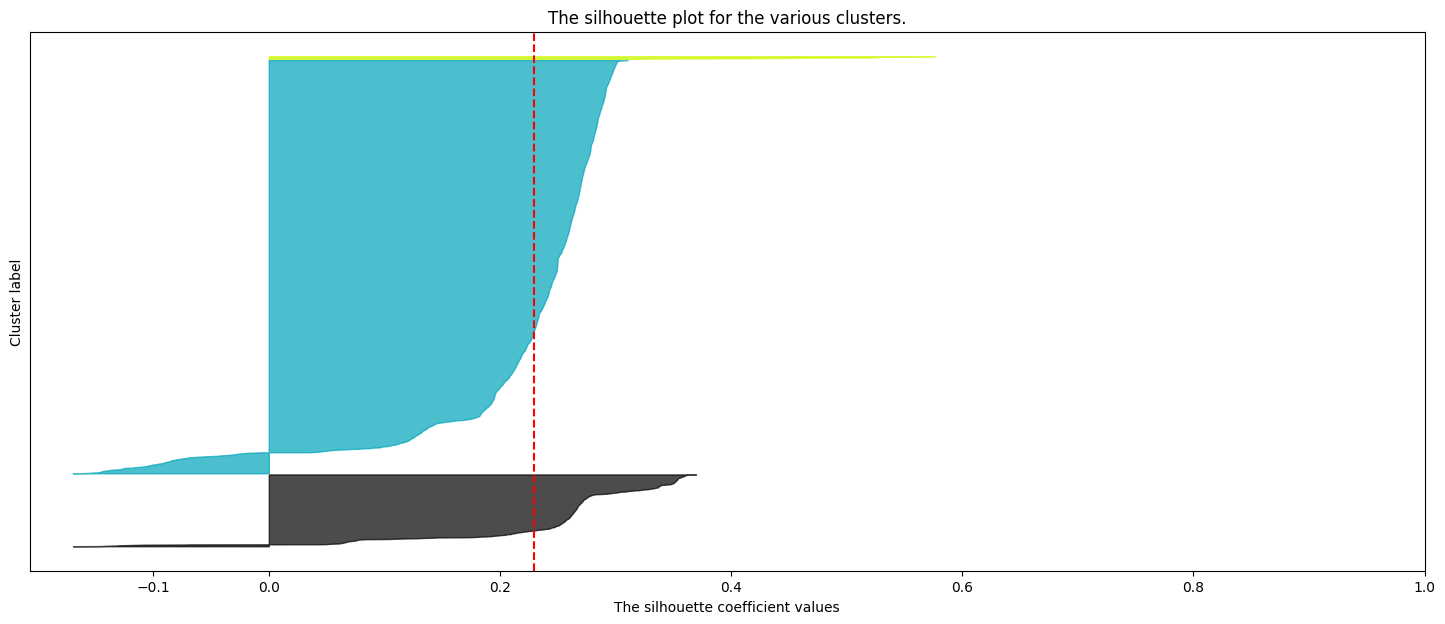

Silhouette Score for 4 clusters using single linkage: 0.20319717260685913


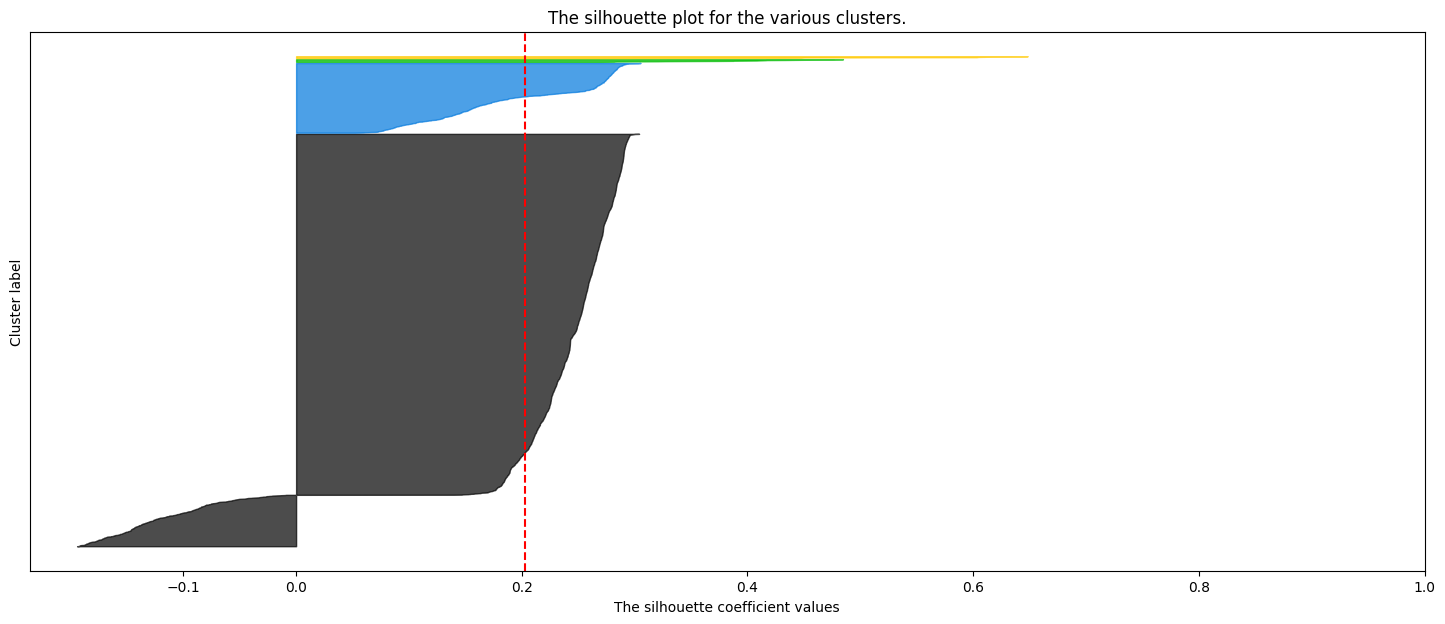

Silhouette Score for 5 clusters using single linkage: 0.20595456490568523


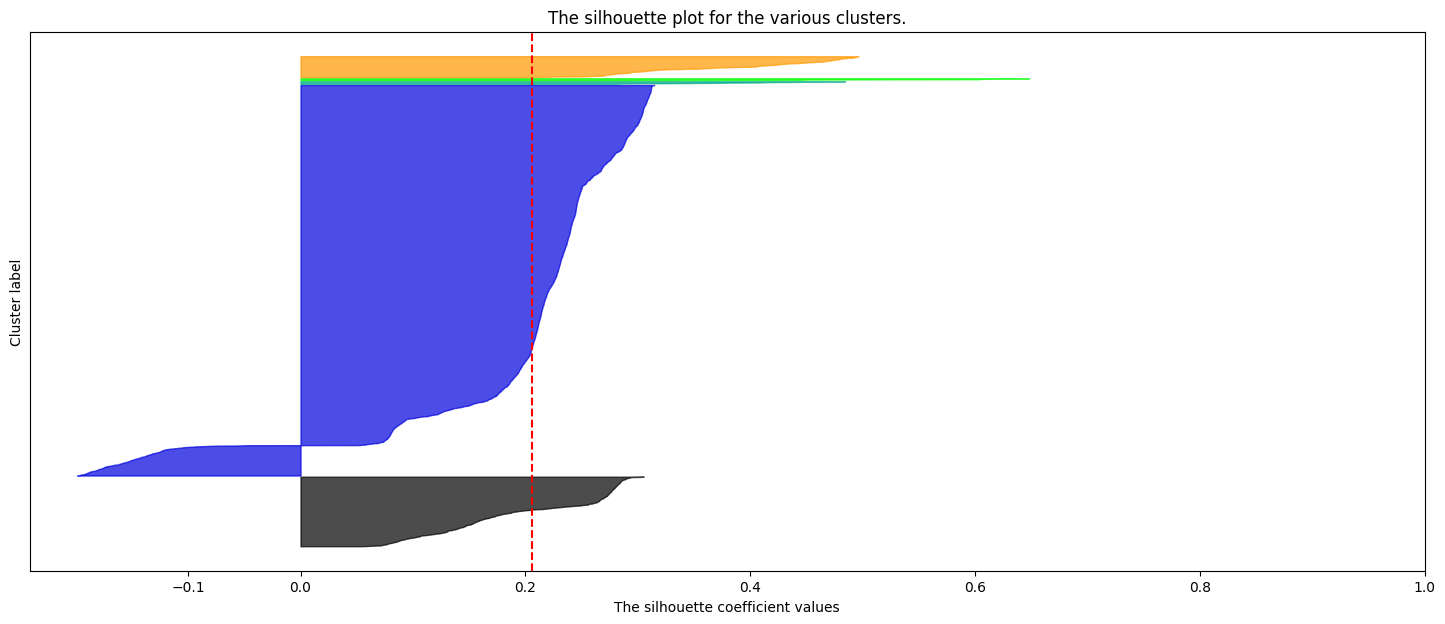

Silhouette Score for 6 clusters using single linkage: 0.18178959095535252


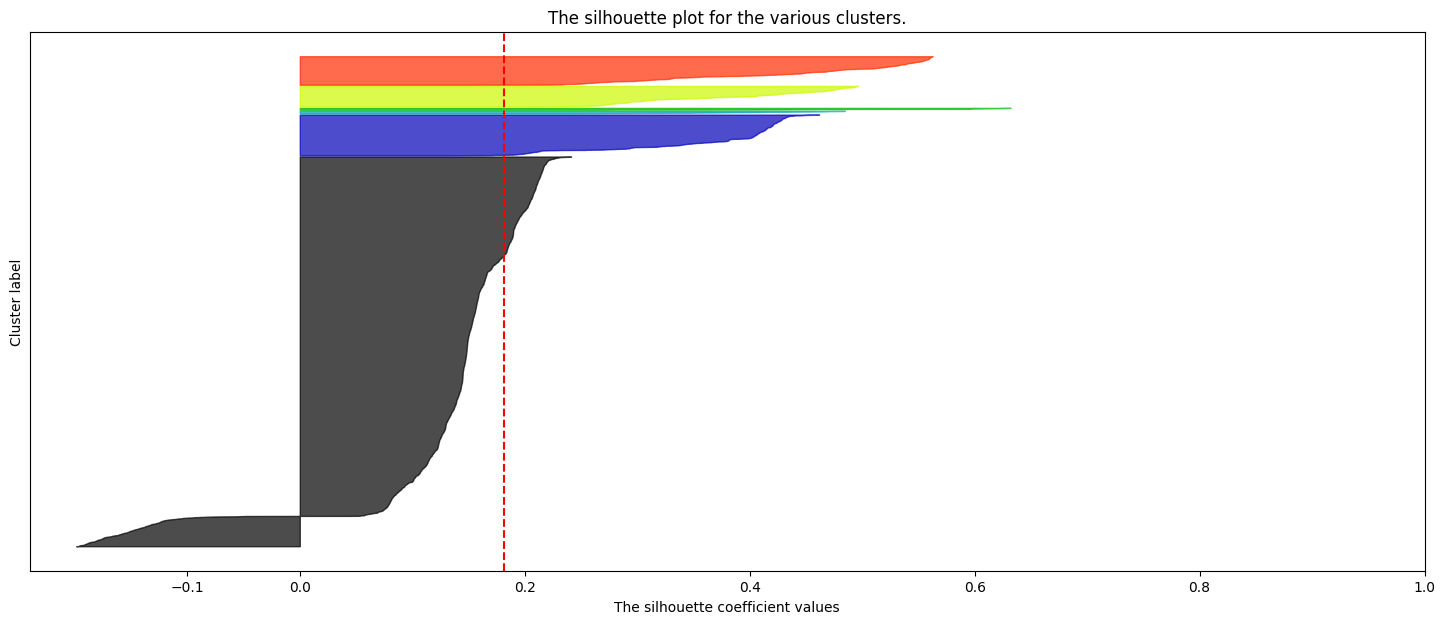

Silhouette Score for 7 clusters using single linkage: 0.3418276048468355


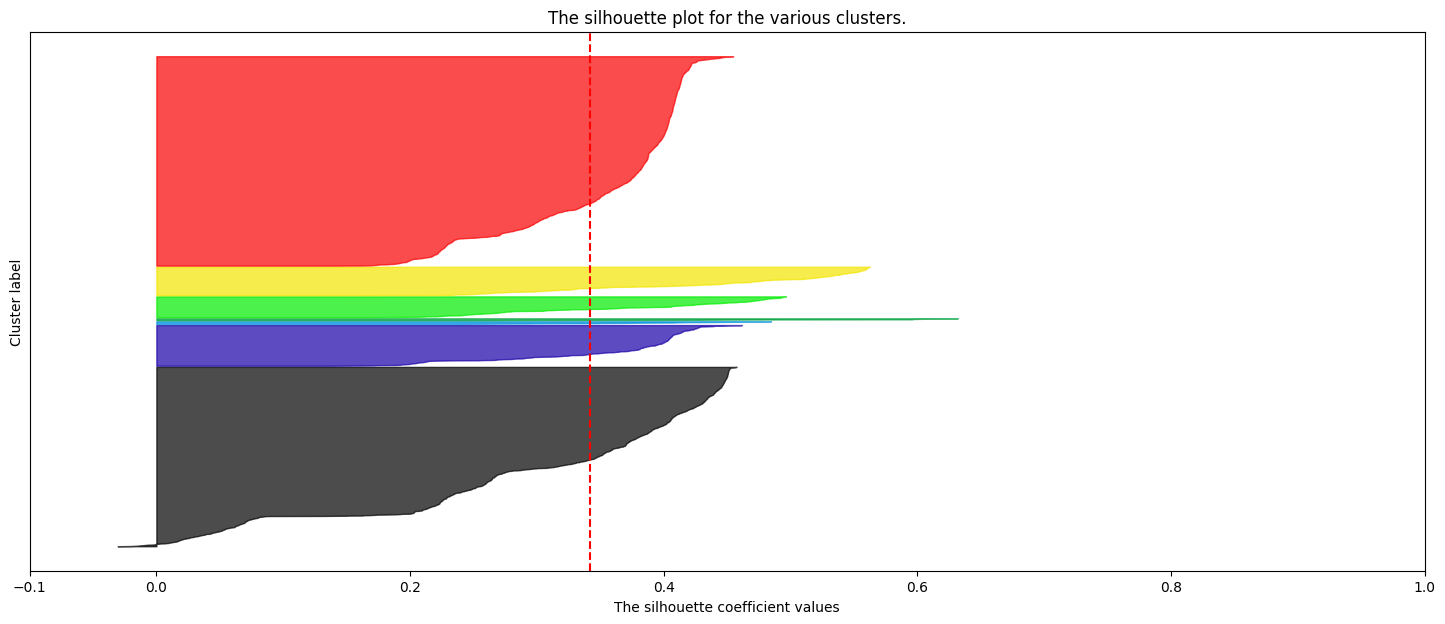

Silhouette Score for 8 clusters using single linkage: 0.38246510553911073


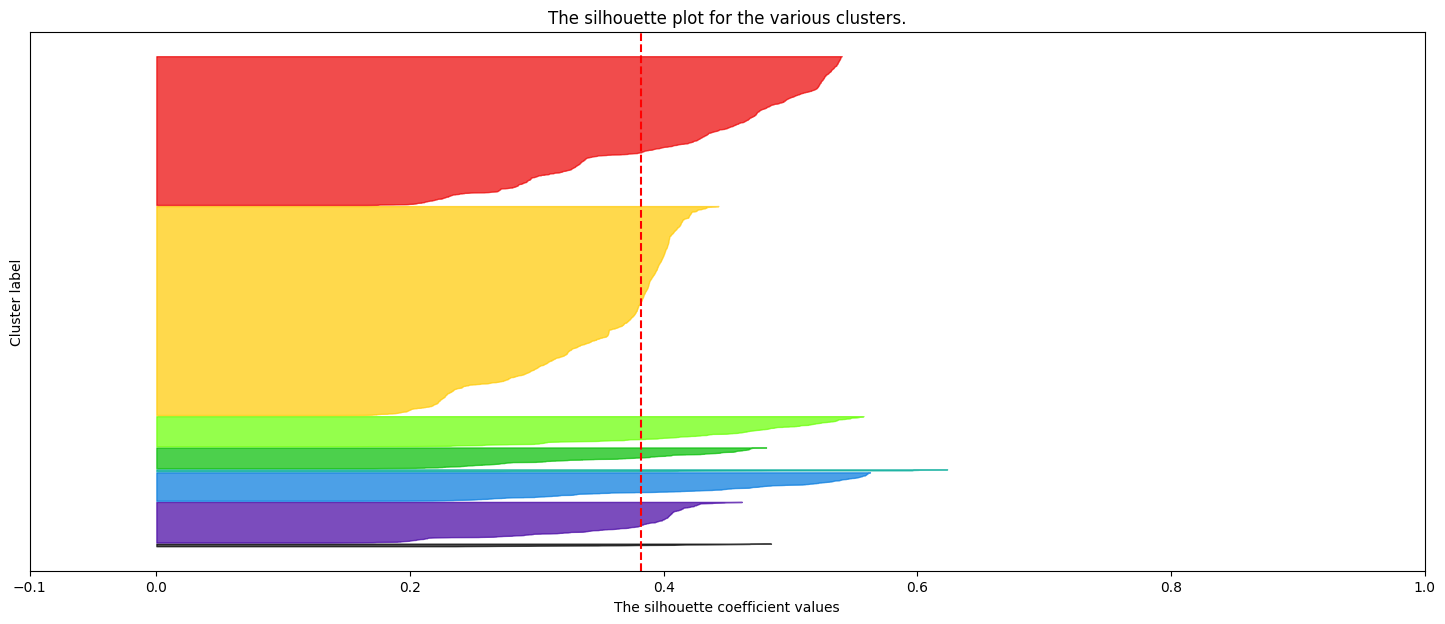

Silhouette Score for 9 clusters using single linkage: 0.3744391887263825


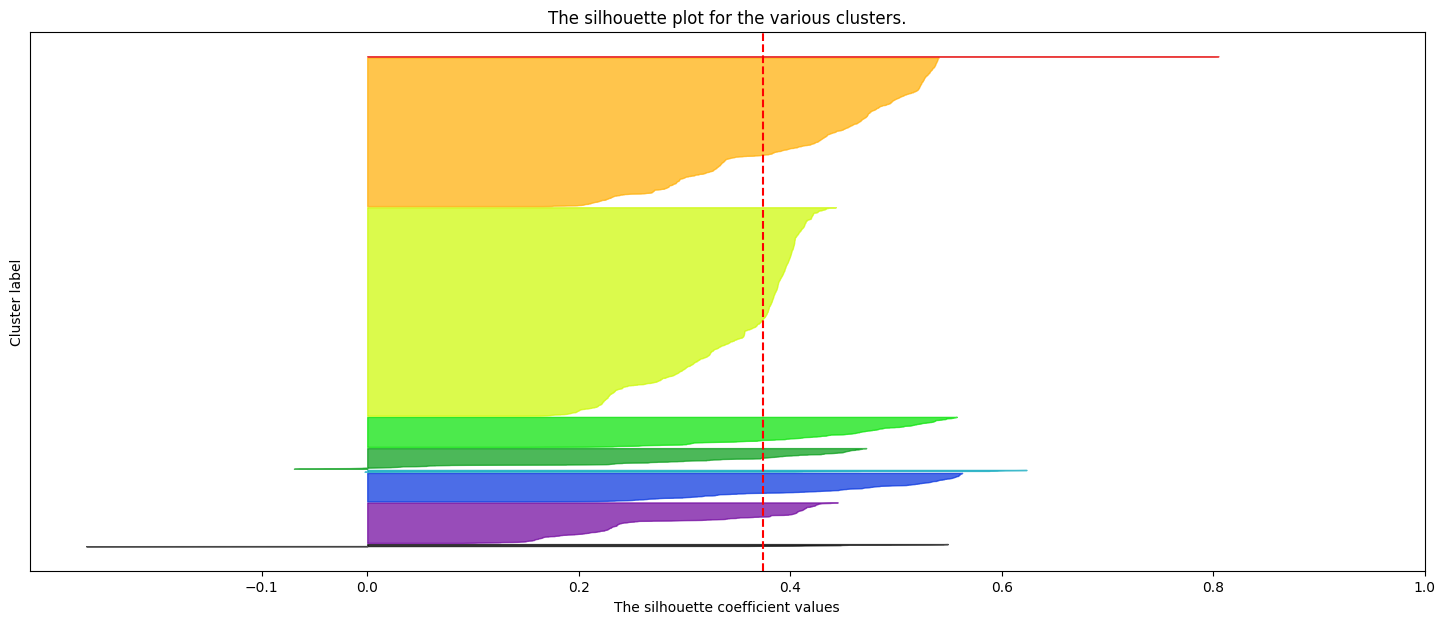

Silhouette Score for 10 clusters using single linkage: 0.3716687690502862


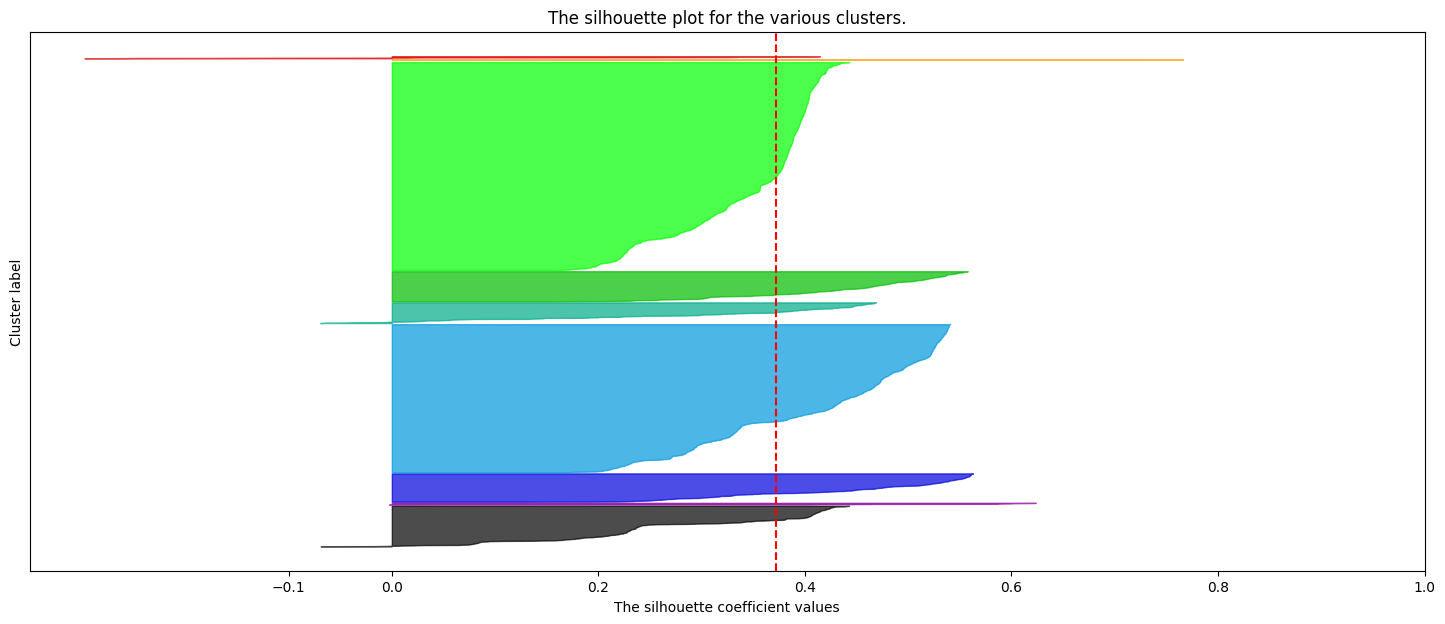

Silhouette Score for 11 clusters using single linkage: 0.3598073970938015


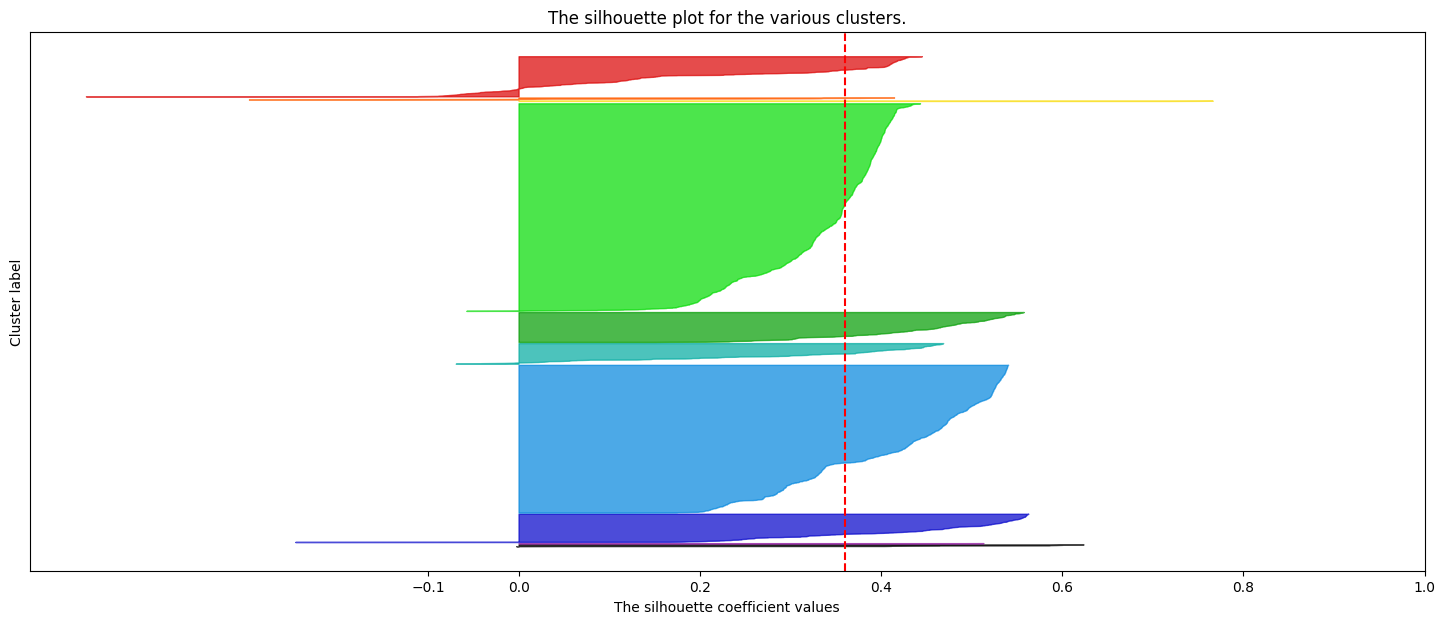

Silhouette Score for 12 clusters using single linkage: 0.3560031817296972


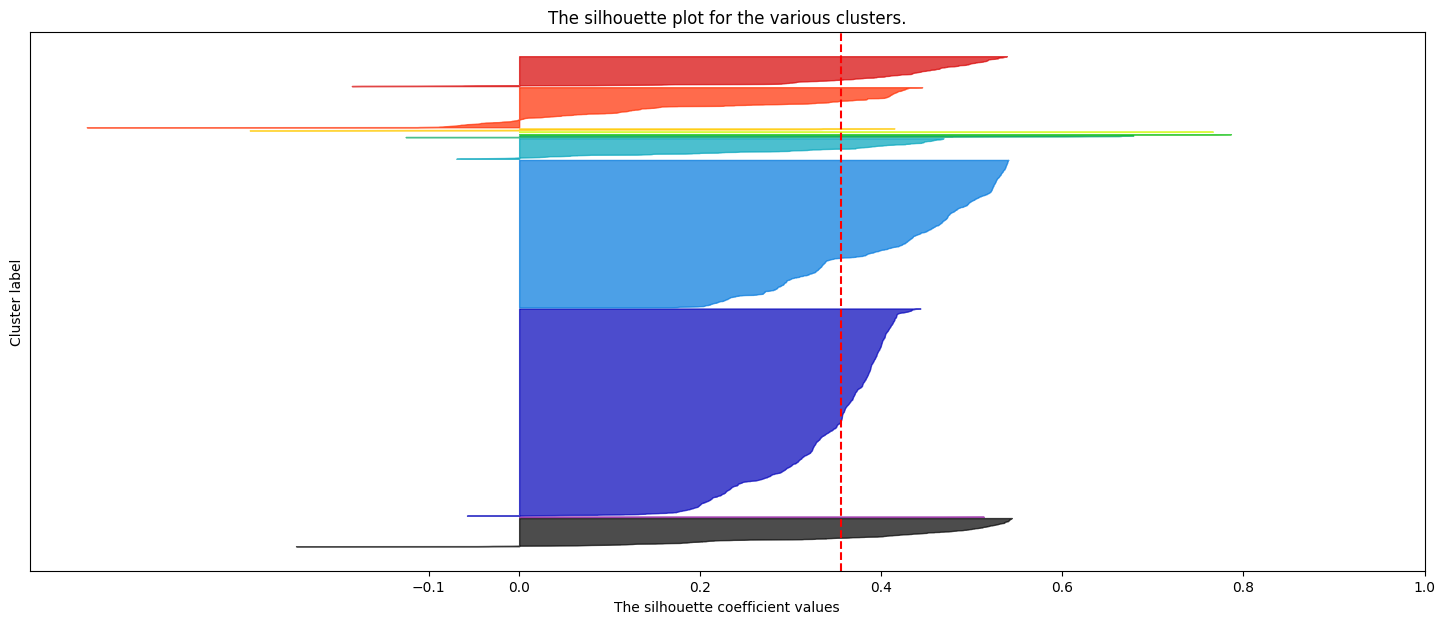

Silhouette Score for 13 clusters using single linkage: 0.3514481407937046


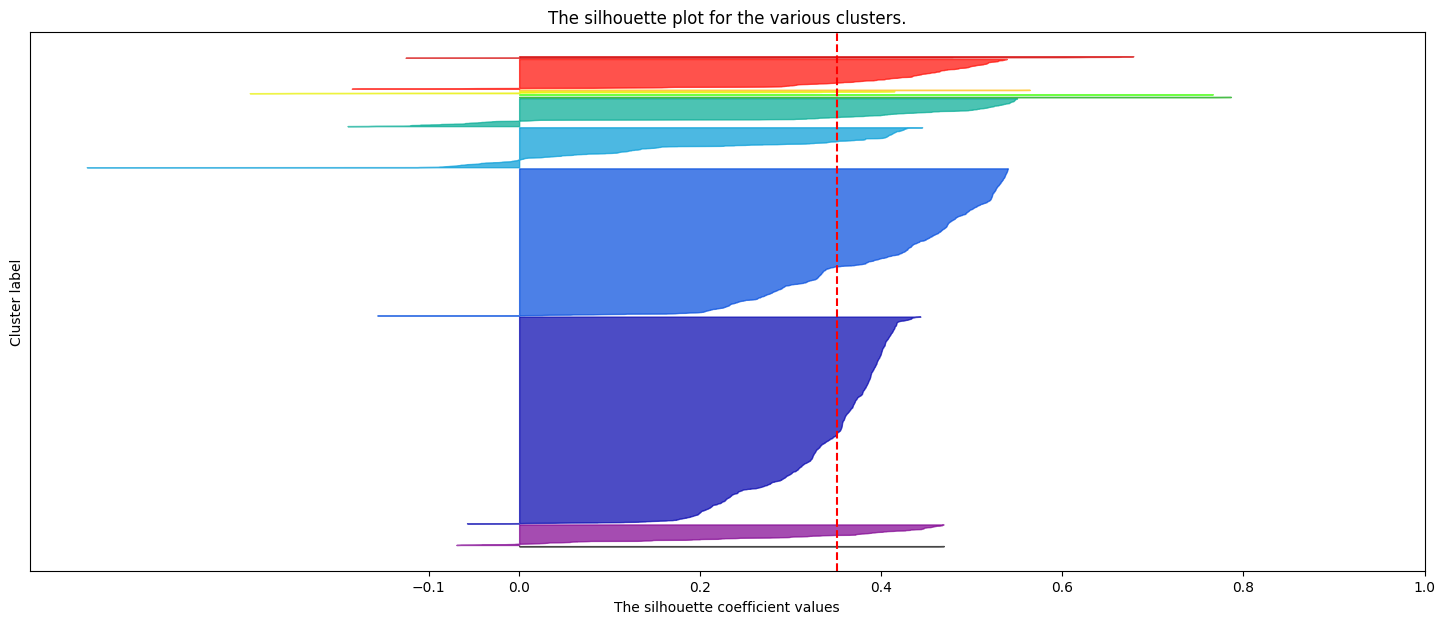

Silhouette Score for 14 clusters using single linkage: 0.3357860599547045


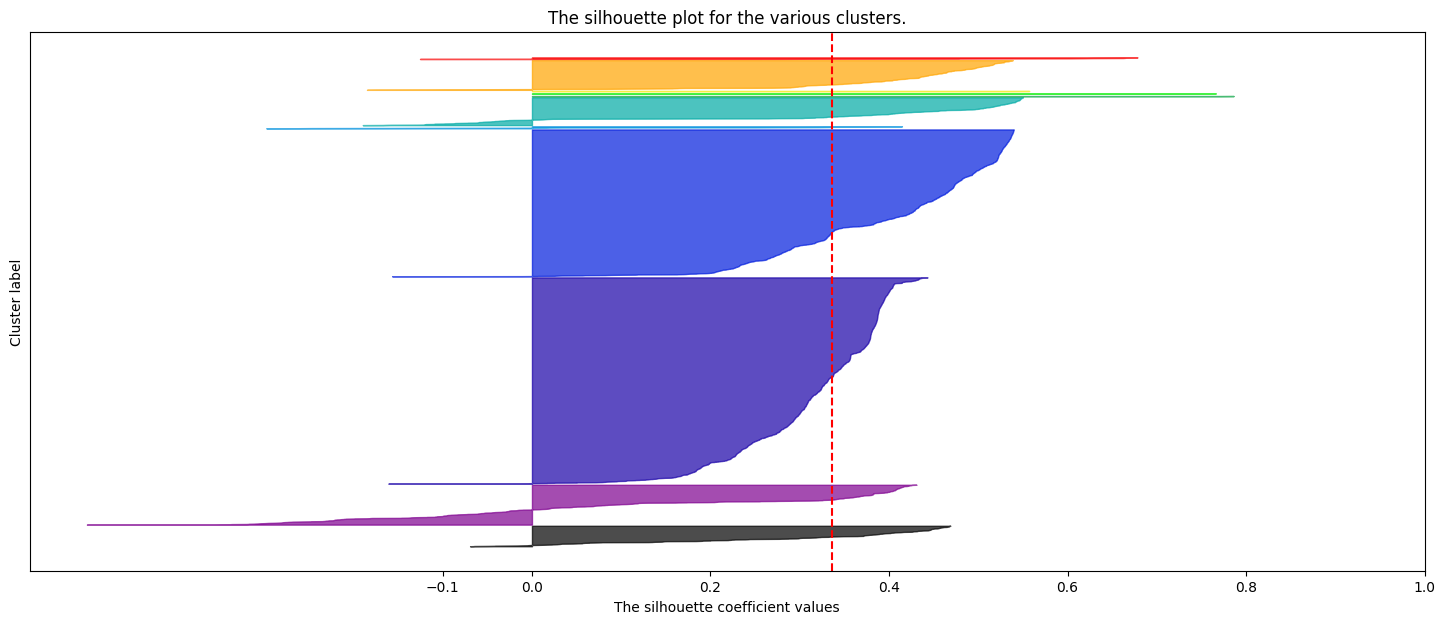

Silhouette Score for 15 clusters using single linkage: 0.32807219305243235


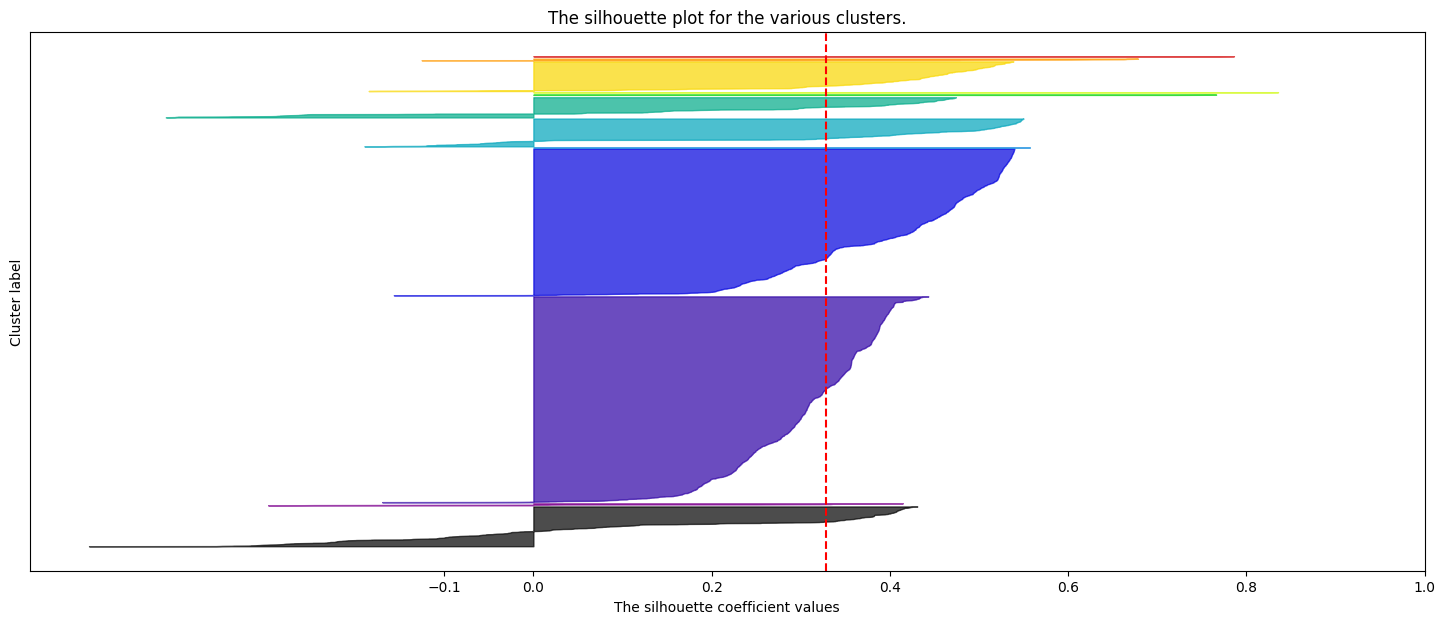

Inconsistency Coefficients for the last 10 cluster merges using complete:
[[ 0.69898914  0.44864115 29.          2.96559963]
 [ 0.72944621  0.55986629 28.          2.55787198]
 [ 0.86126249  0.48615769 29.          2.73717962]
 [ 0.77361513  0.53641078 29.          2.64548228]
 [ 1.07978677  0.52473775 31.          2.19927331]
 [ 1.01493851  0.54717664 31.          2.35301741]
 [ 1.02315557  0.51092191 31.          2.55377869]
 [ 1.24856072  0.56686999 31.          1.93480506]
 [ 1.47560703  0.50684021 31.          2.19895151]
 [ 1.80096555  0.42658254 31.          2.0211918 ]]
Unique clusters identified at cut depth using complete:
[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15]


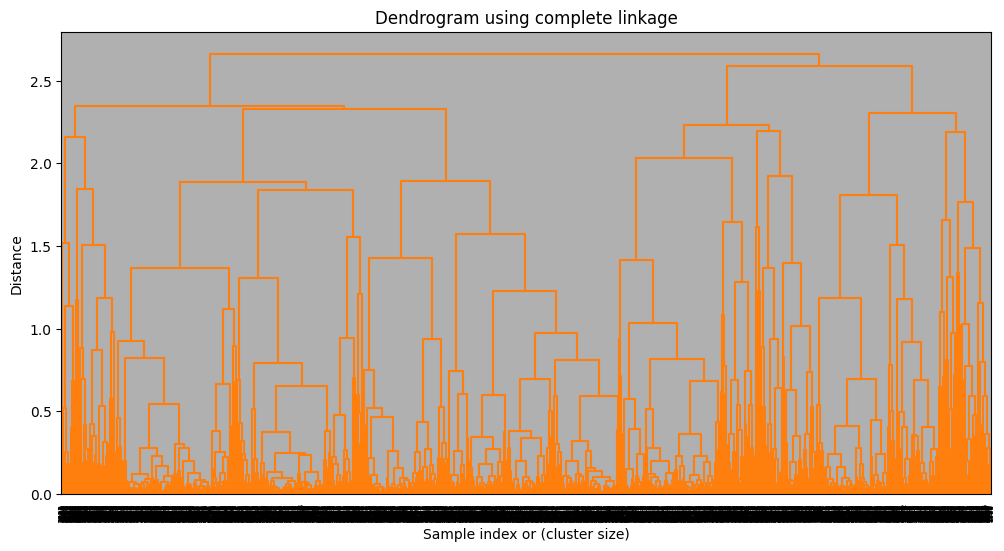

Silhouette Score for 2 clusters using complete linkage: 0.10149087343040311


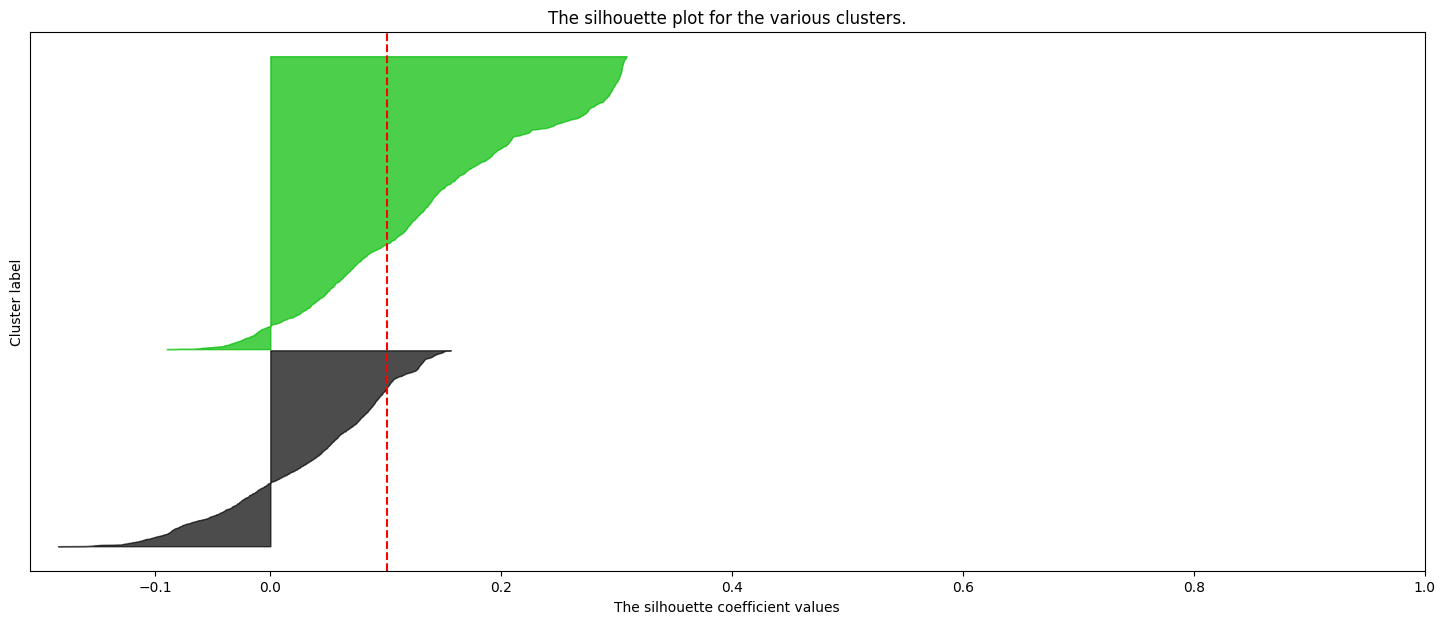

Silhouette Score for 3 clusters using complete linkage: 0.10070634584585596


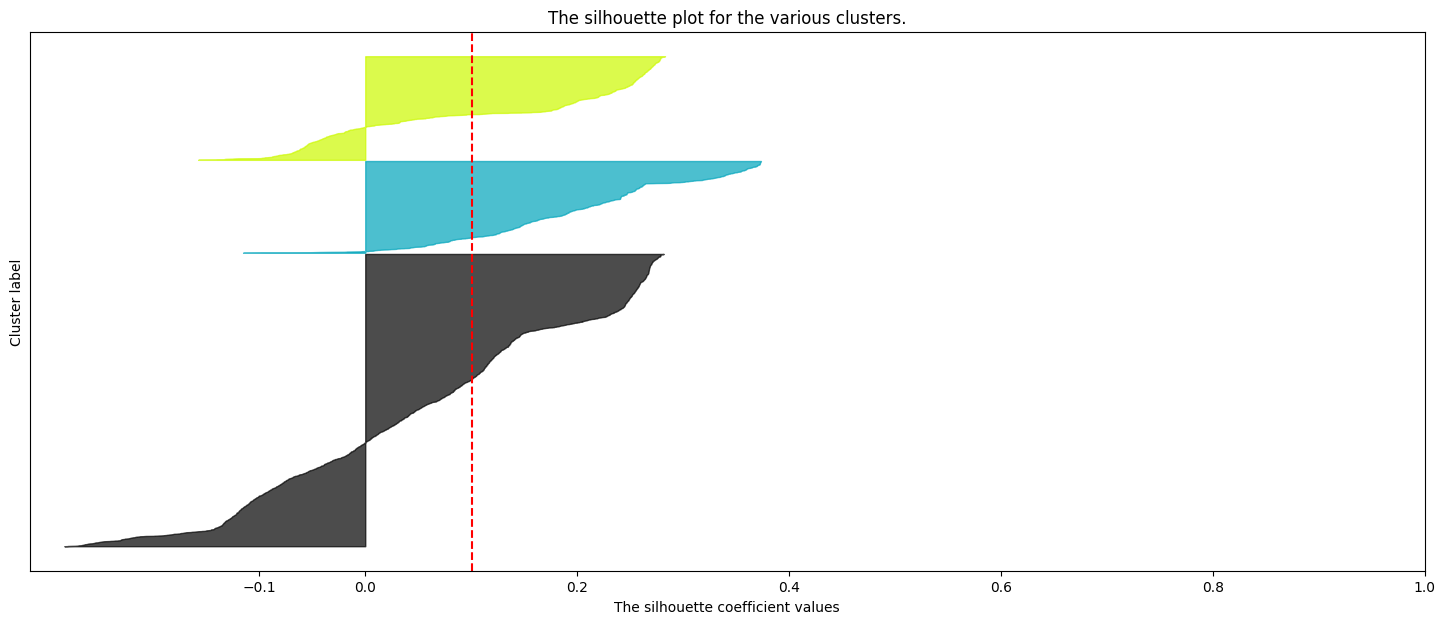

Silhouette Score for 4 clusters using complete linkage: 0.10514976780529028


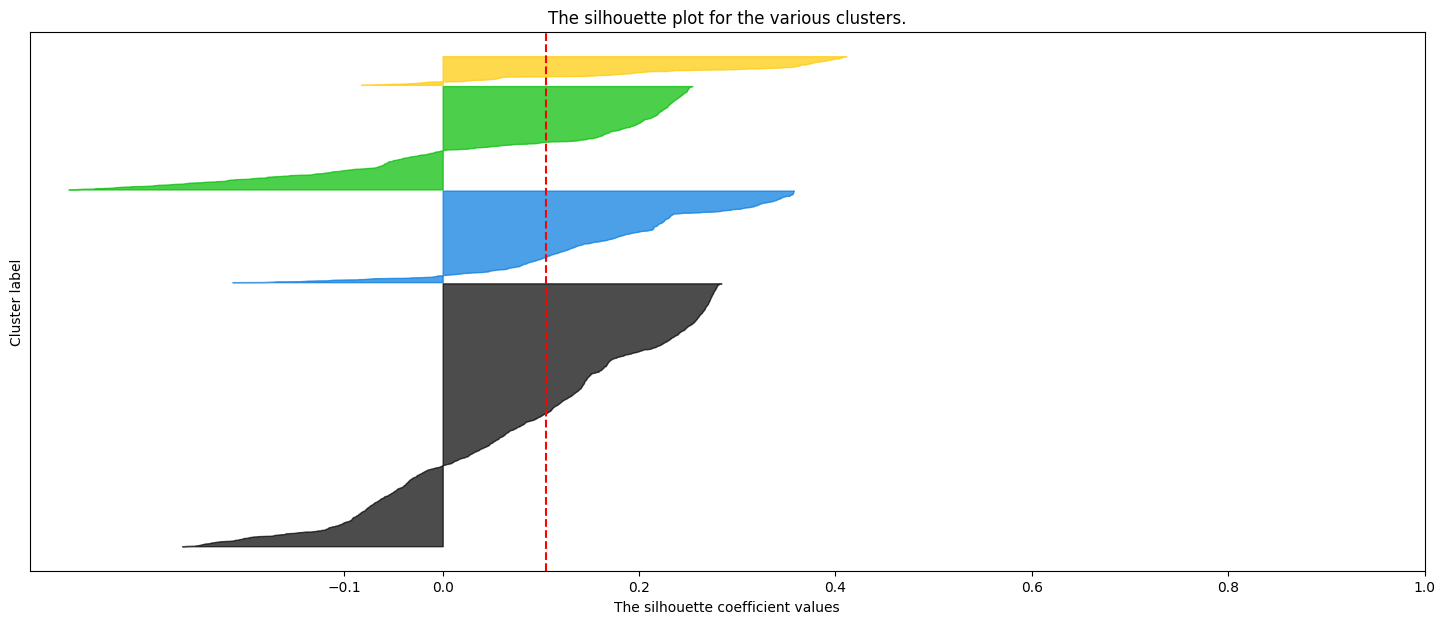

Silhouette Score for 5 clusters using complete linkage: 0.19380132199177003


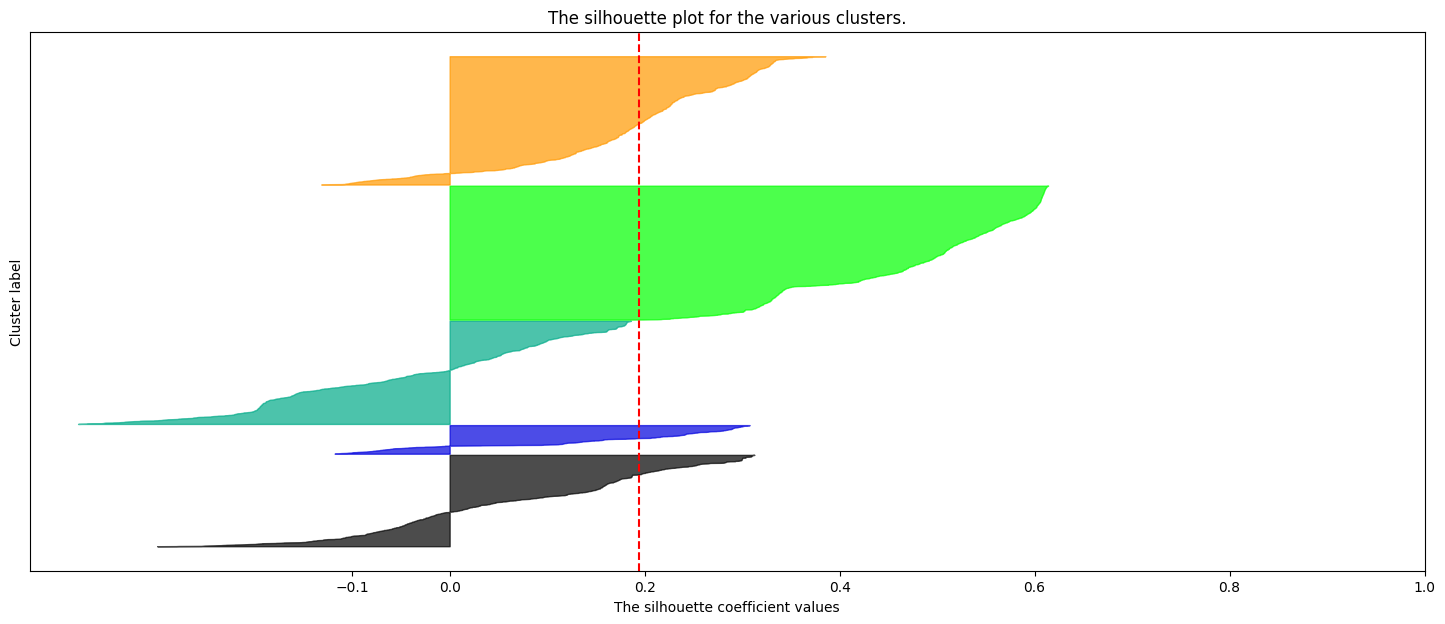

Silhouette Score for 6 clusters using complete linkage: 0.20274018099922547


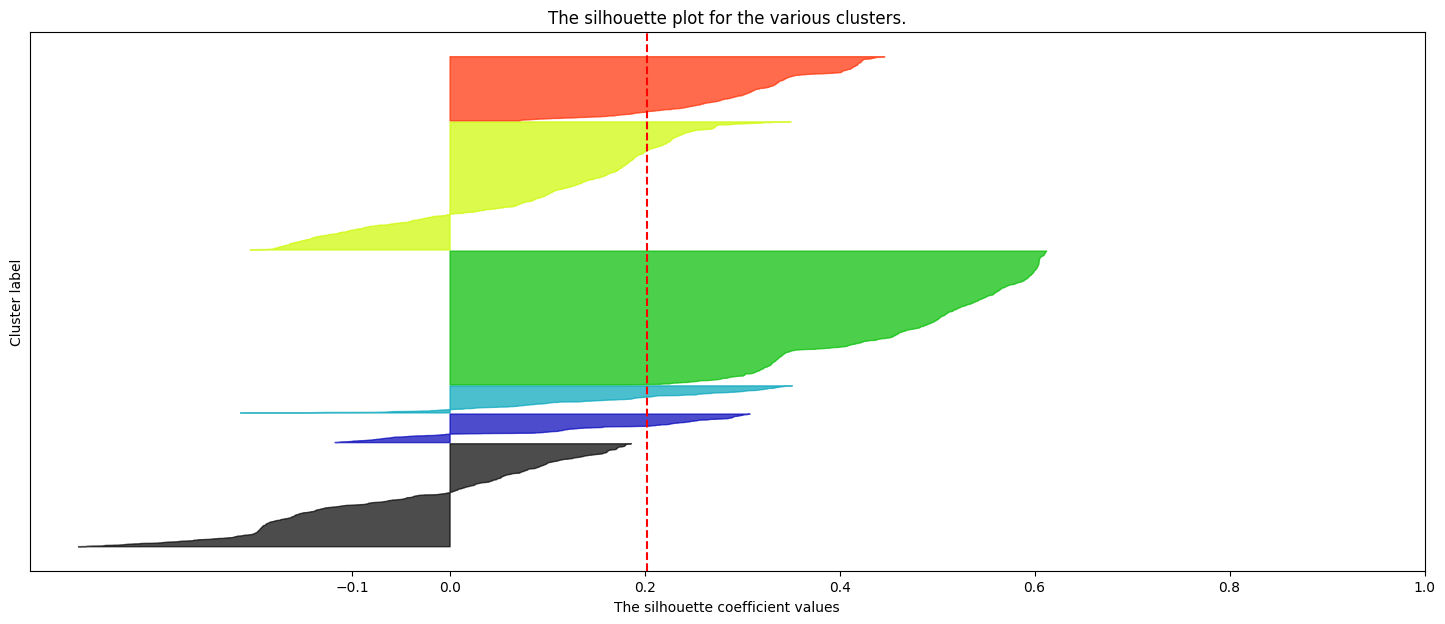

Silhouette Score for 7 clusters using complete linkage: 0.22711333893798208


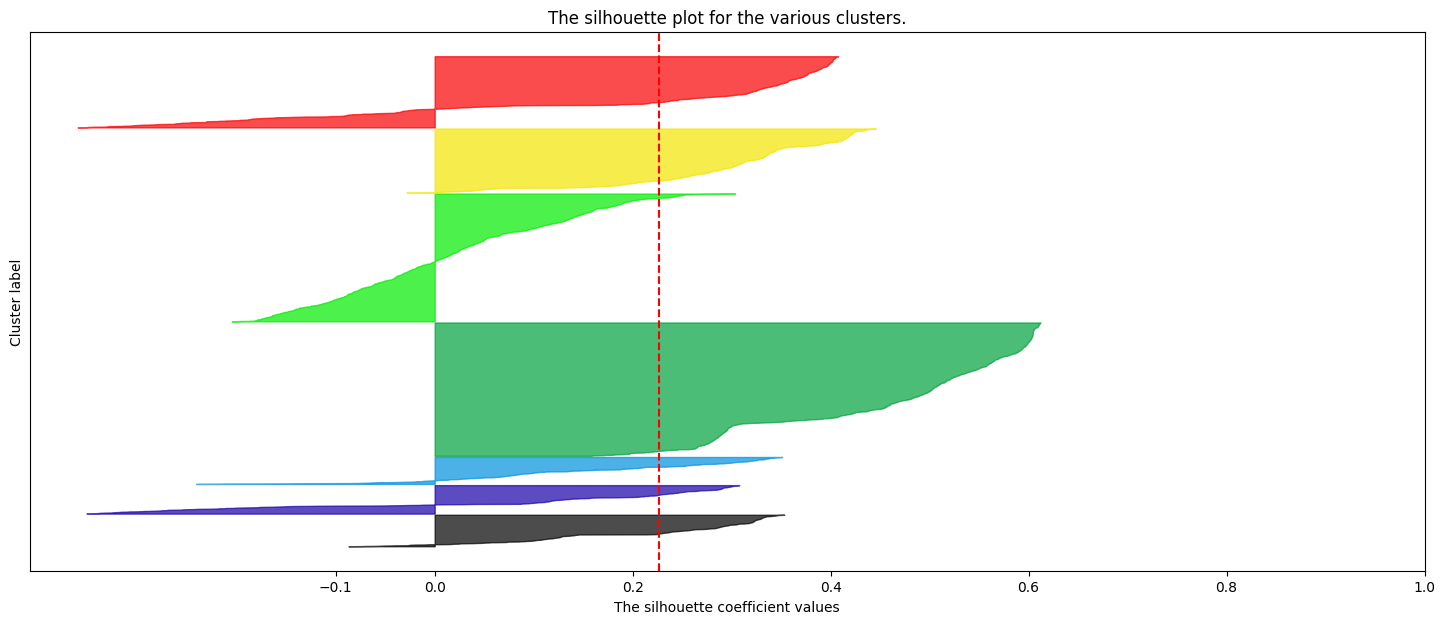

Silhouette Score for 8 clusters using complete linkage: 0.2301797284083964


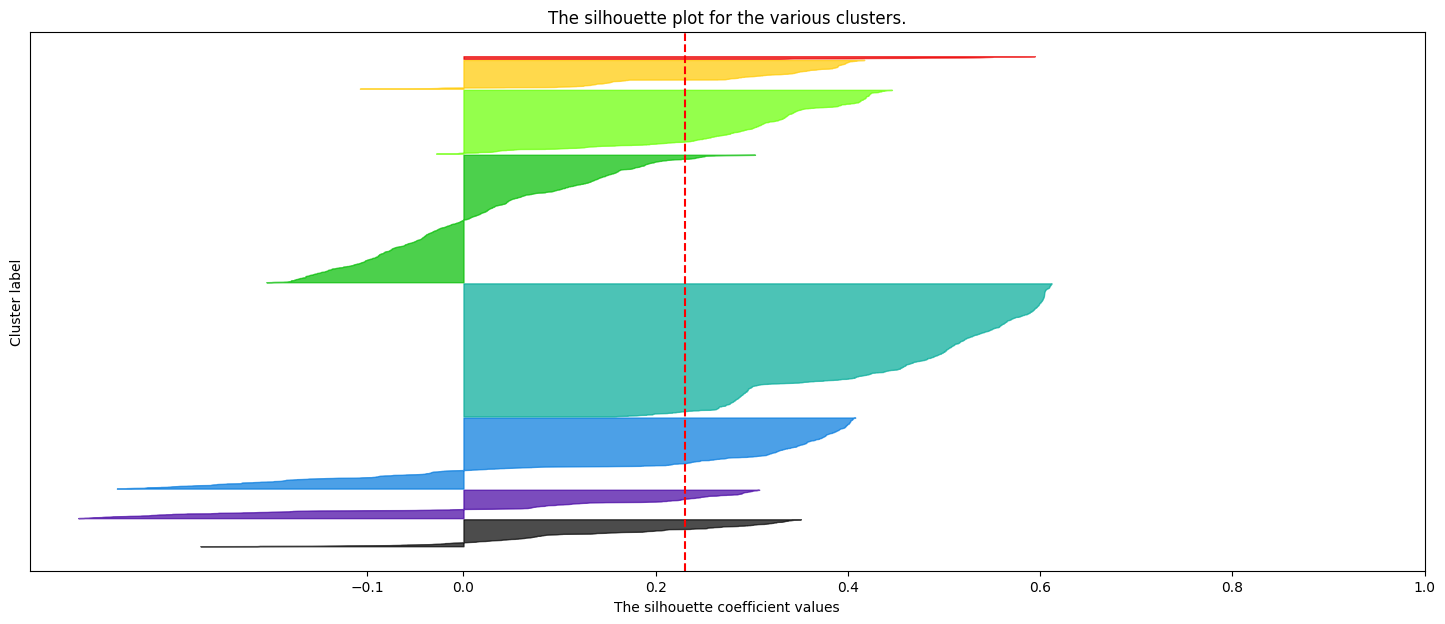

Silhouette Score for 9 clusters using complete linkage: 0.22658928104560286


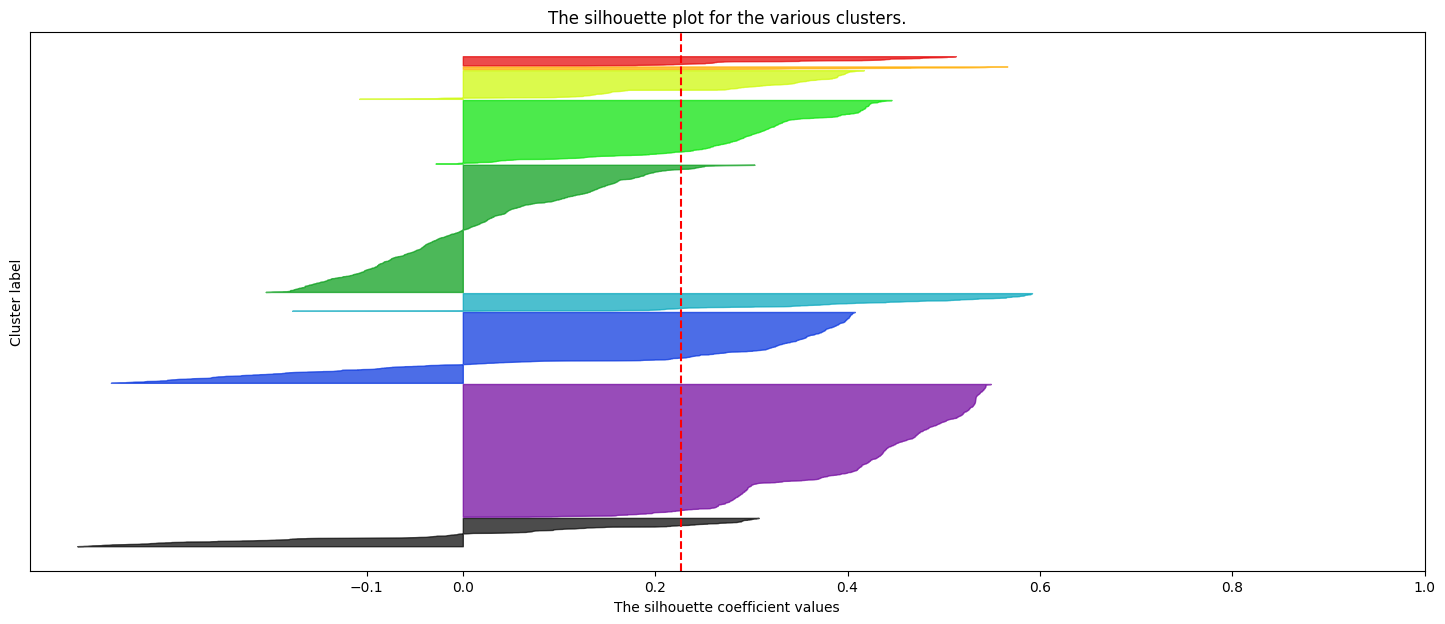

Silhouette Score for 10 clusters using complete linkage: 0.22438389601163675


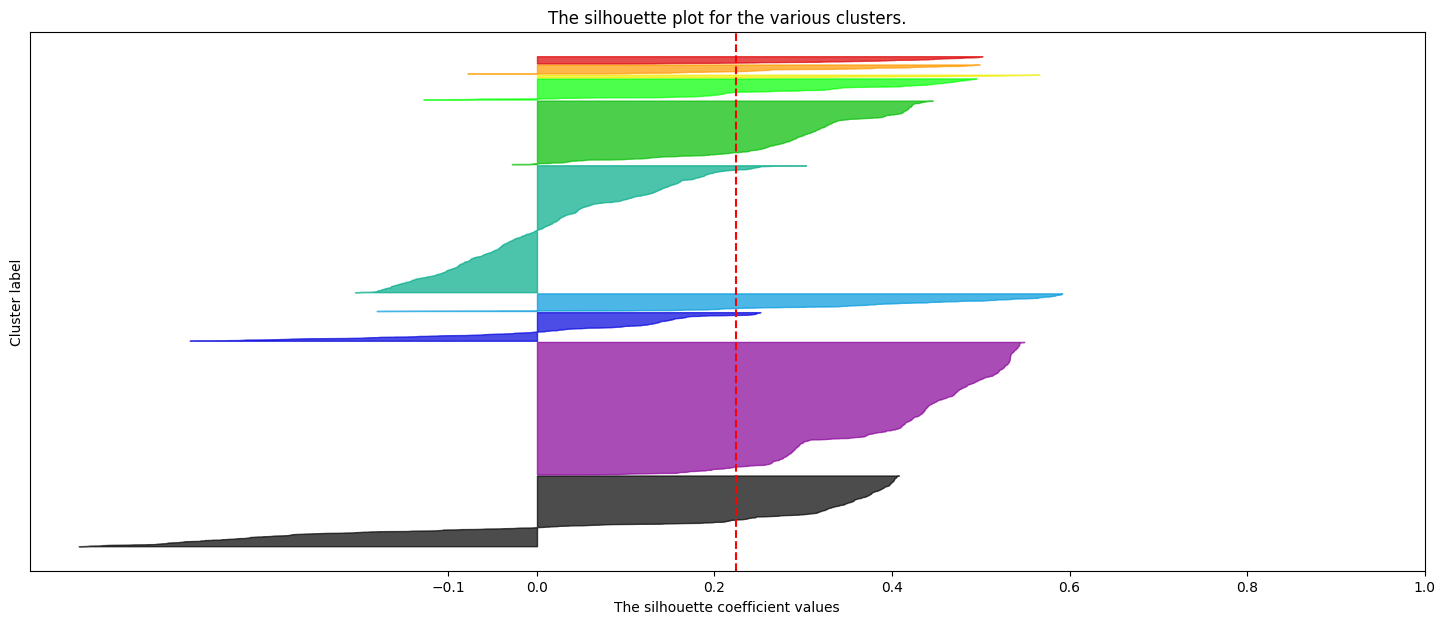

Silhouette Score for 11 clusters using complete linkage: 0.23305386551154614


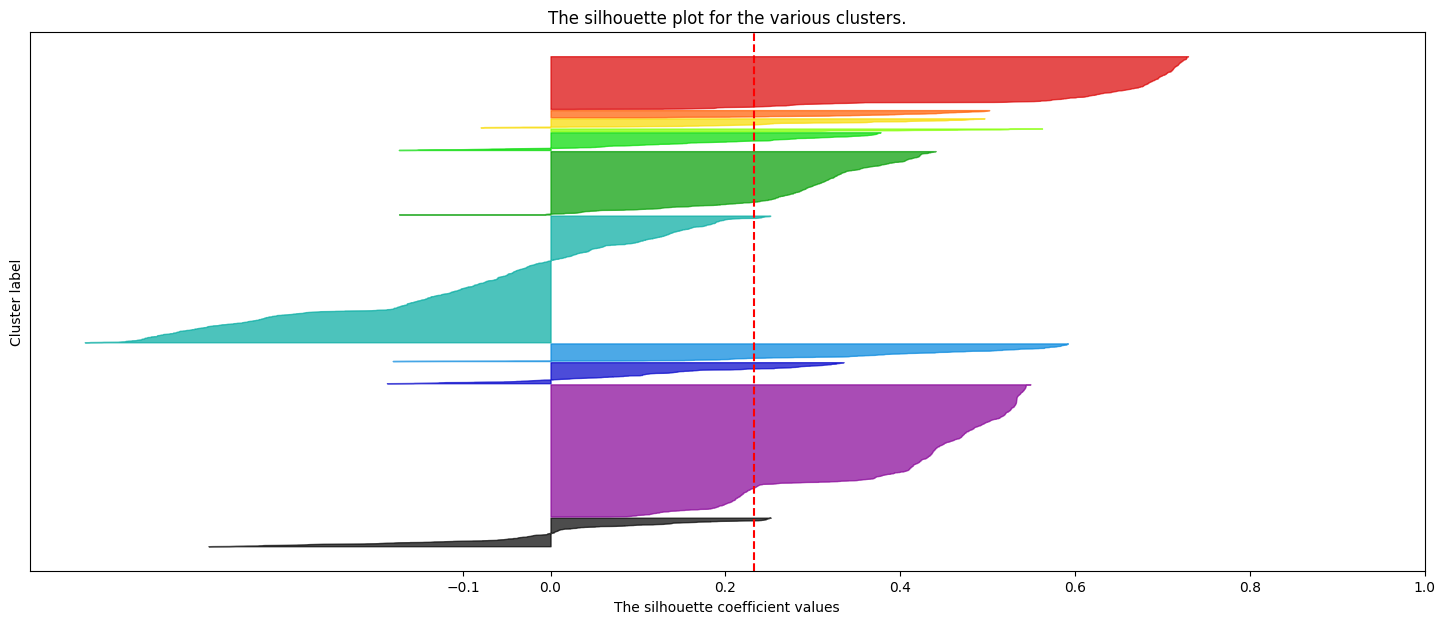

Silhouette Score for 12 clusters using complete linkage: 0.24657826915047426


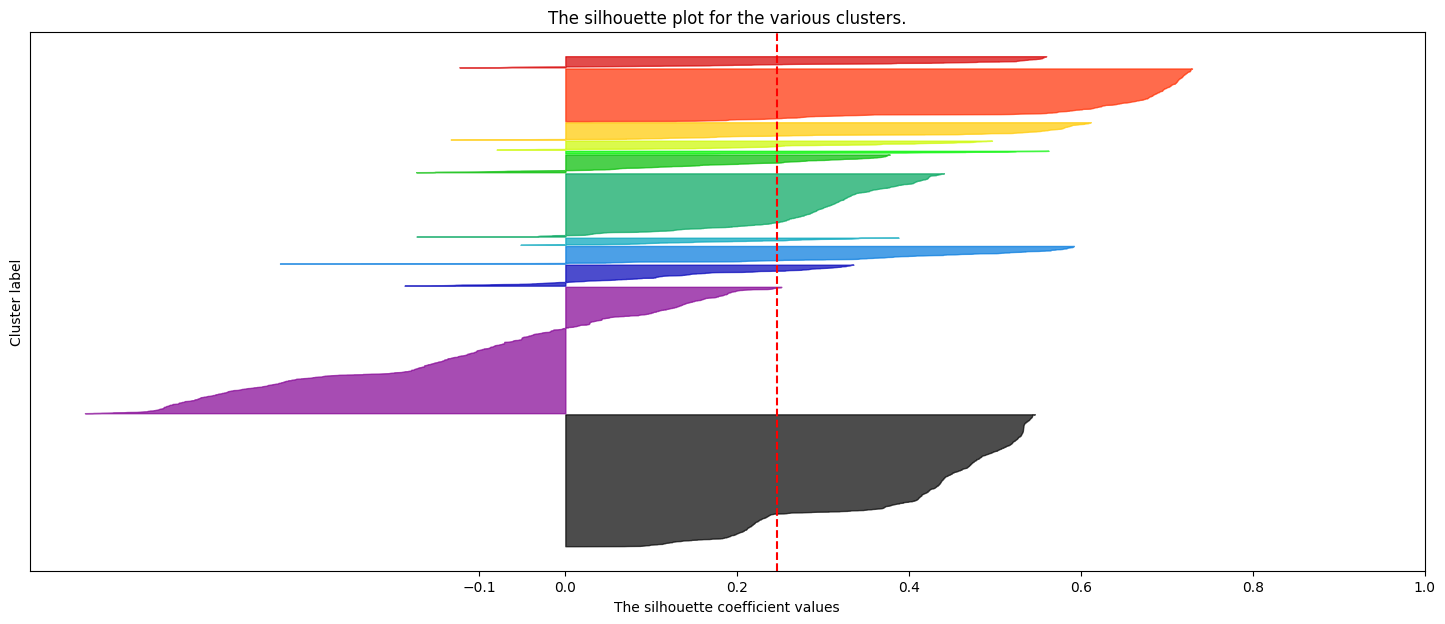

Silhouette Score for 13 clusters using complete linkage: 0.2296928965798127


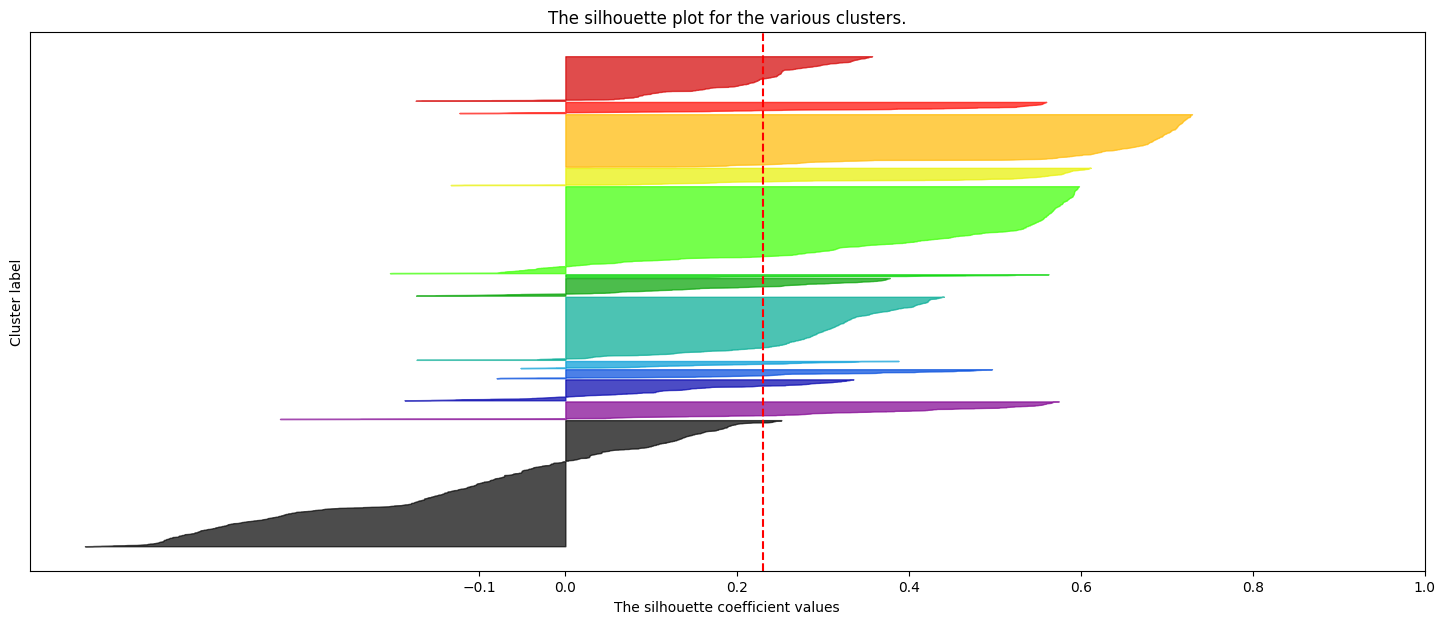

Silhouette Score for 14 clusters using complete linkage: 0.26726241177903043


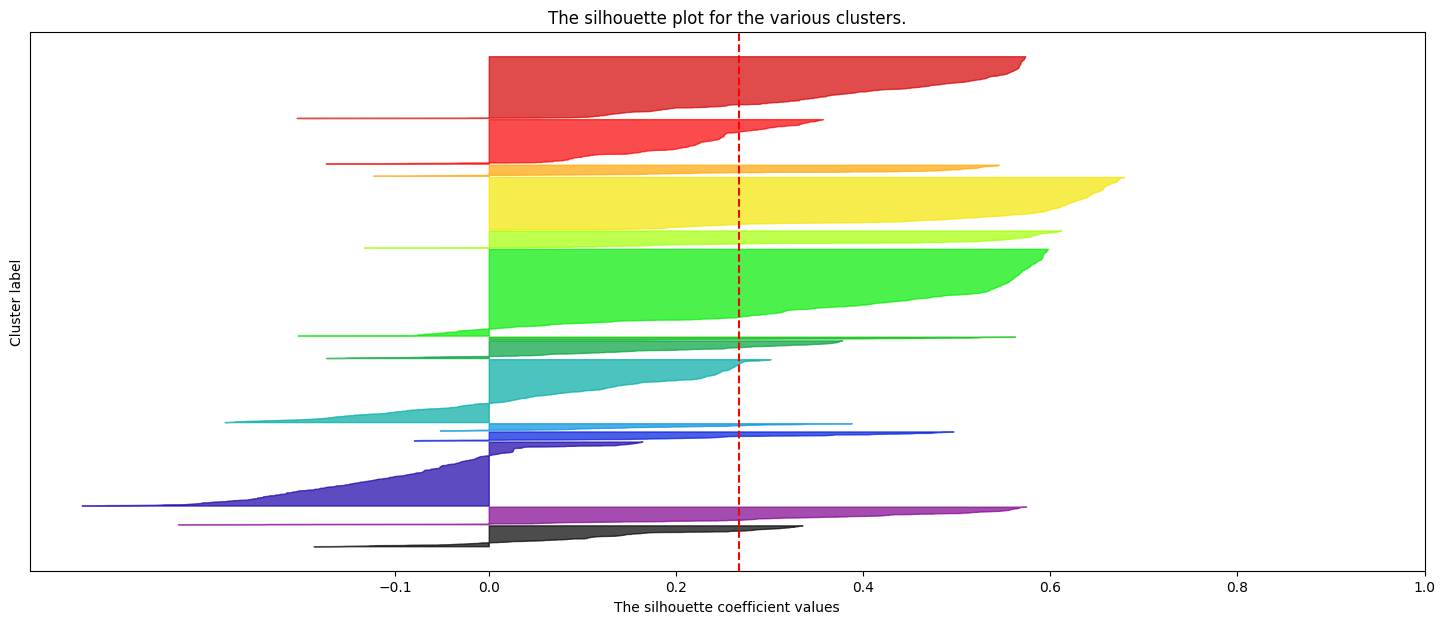

Silhouette Score for 15 clusters using complete linkage: 0.2678136087780683


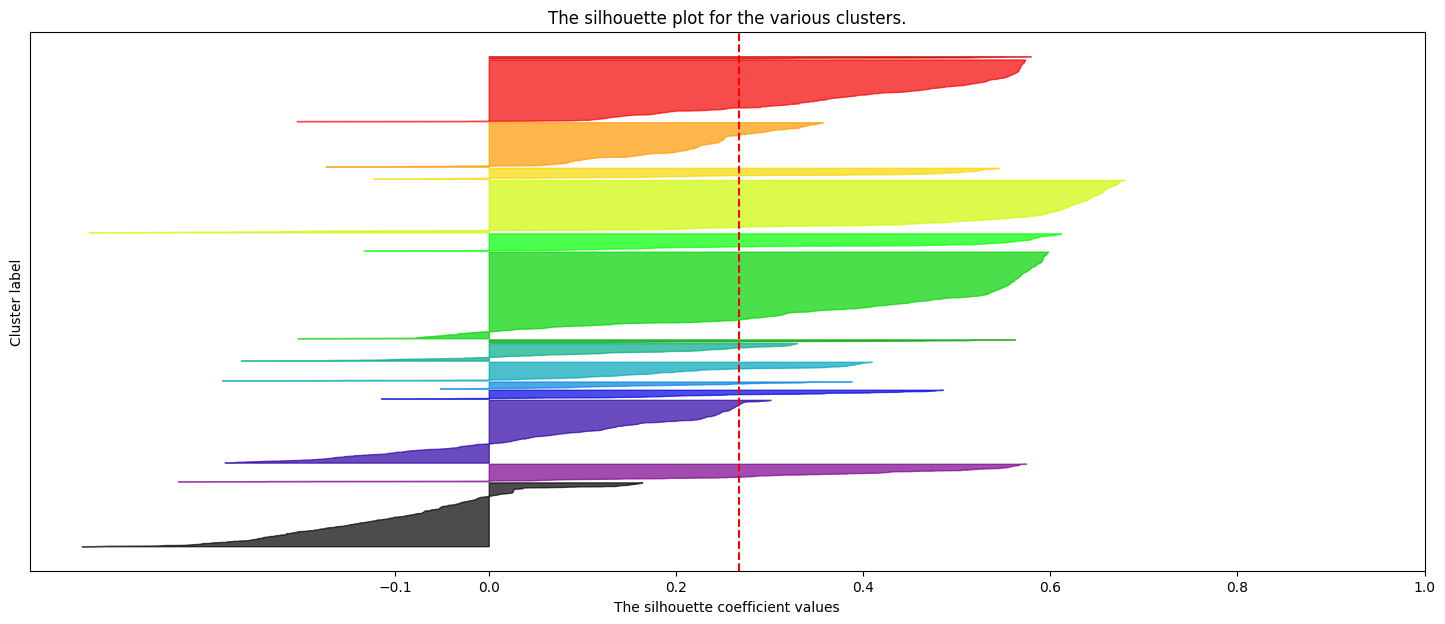

Inconsistency Coefficients for the last 10 cluster merges using average:
[[ 0.47878699  0.3466522  21.          2.04987758]
 [ 0.5545292   0.33986449 29.          1.98024049]
 [ 0.52468682  0.35710432 24.          2.00033272]
 [ 0.52688333  0.28451677 30.          2.5594927 ]
 [ 0.53116883  0.33116285 26.          2.26922833]
 [ 0.64681819  0.32733359 30.          1.99651774]
 [ 0.73530449  0.32915639 31.          1.96410659]
 [ 0.89292899  0.29207242 16.          1.8370053 ]
 [ 1.0416392   0.24638563 24.          1.64922416]
 [ 0.948841    0.36388706 28.          1.66452094]]
Unique clusters identified at cut depth using average:
[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15]


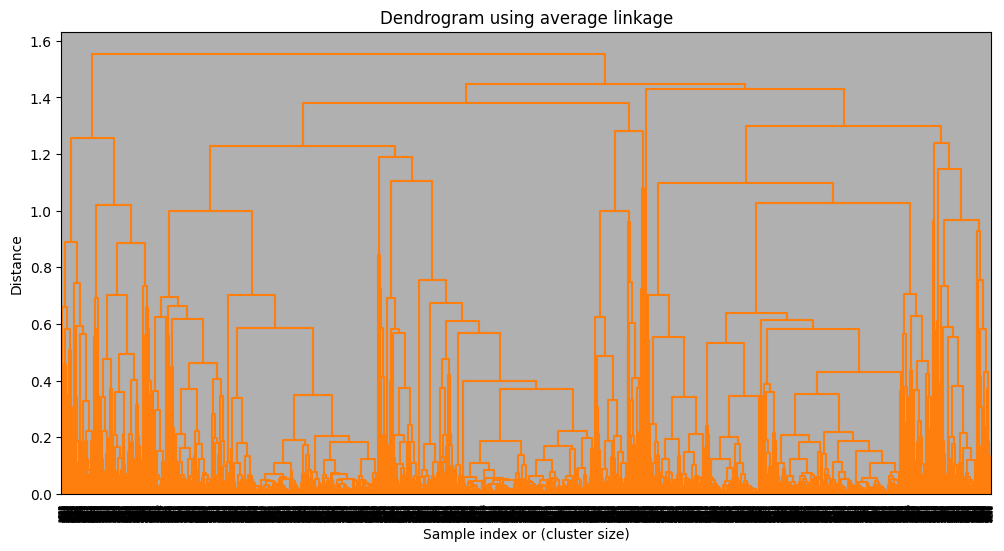

Silhouette Score for 2 clusters using average linkage: 0.2375561310316473


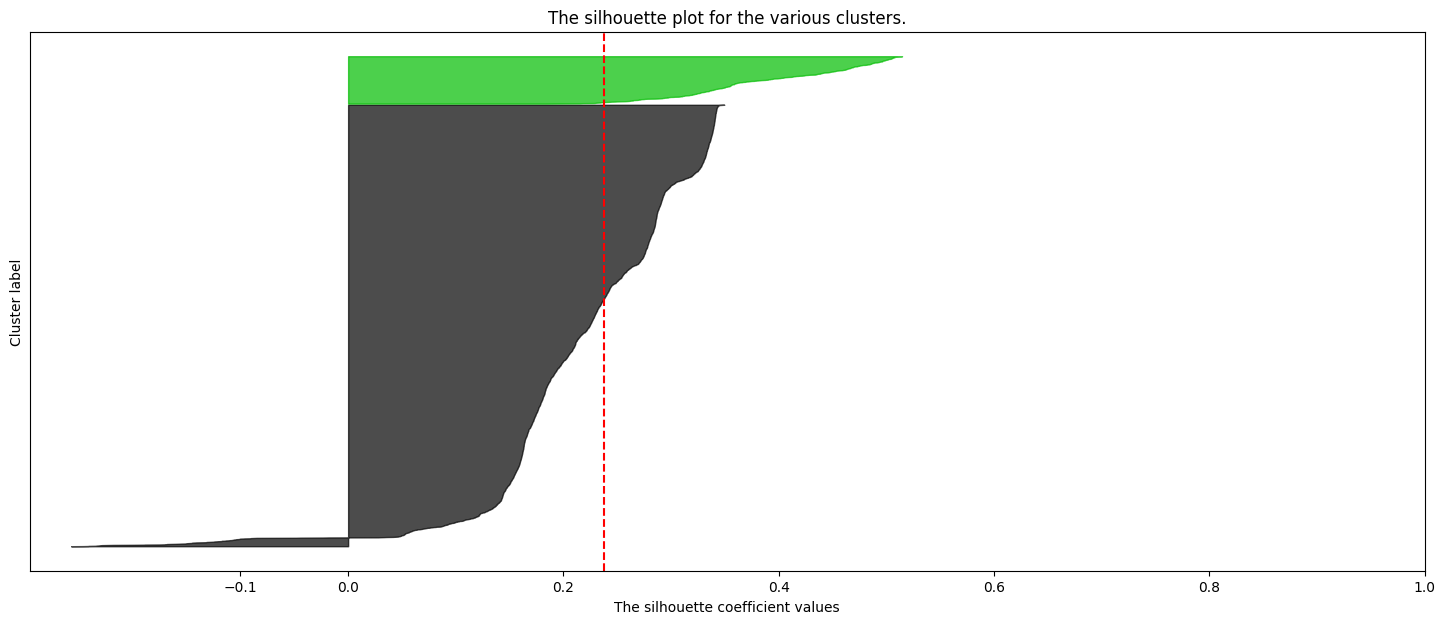

Silhouette Score for 3 clusters using average linkage: 0.3237354512125223


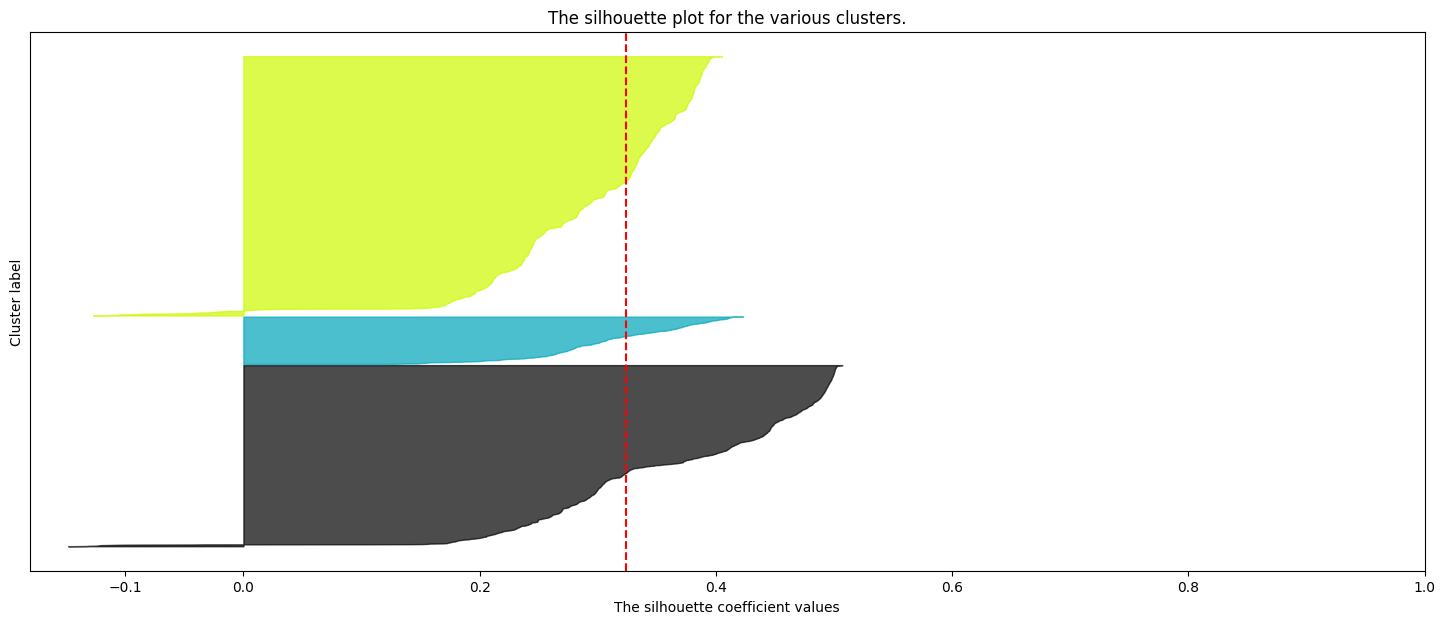

Silhouette Score for 4 clusters using average linkage: 0.29521008757964273


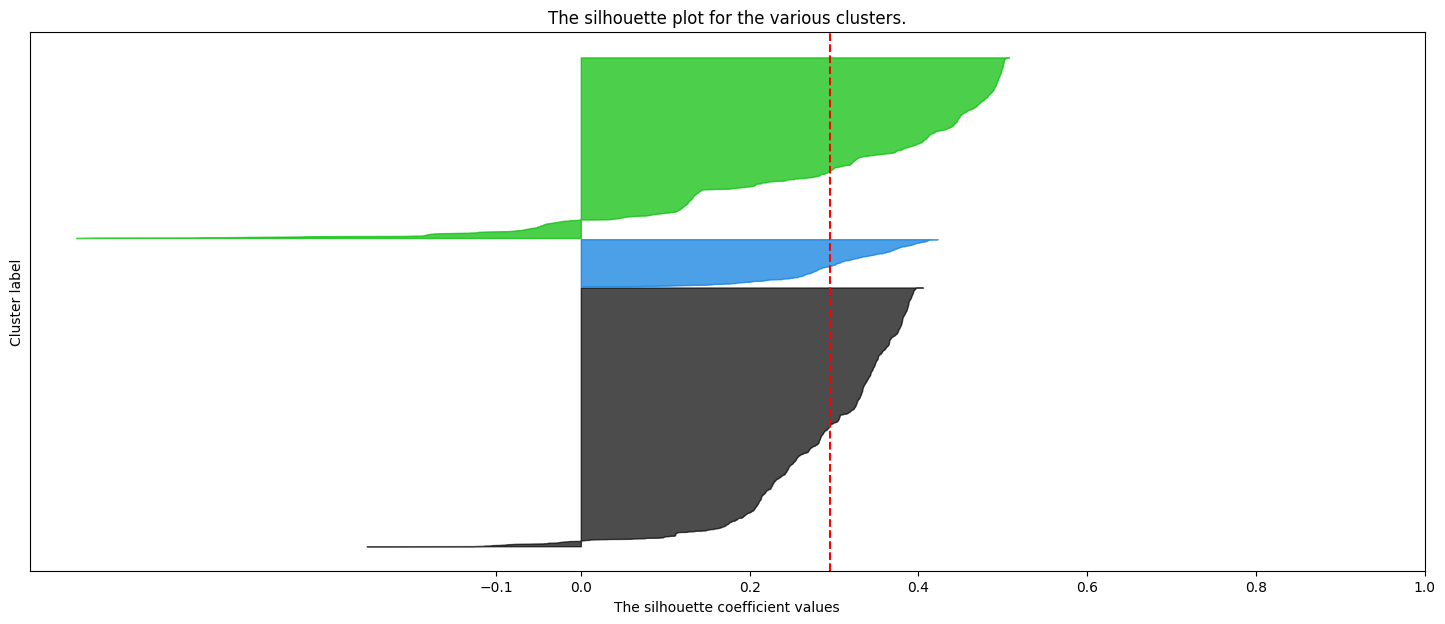

Silhouette Score for 5 clusters using average linkage: 0.2967832398022243


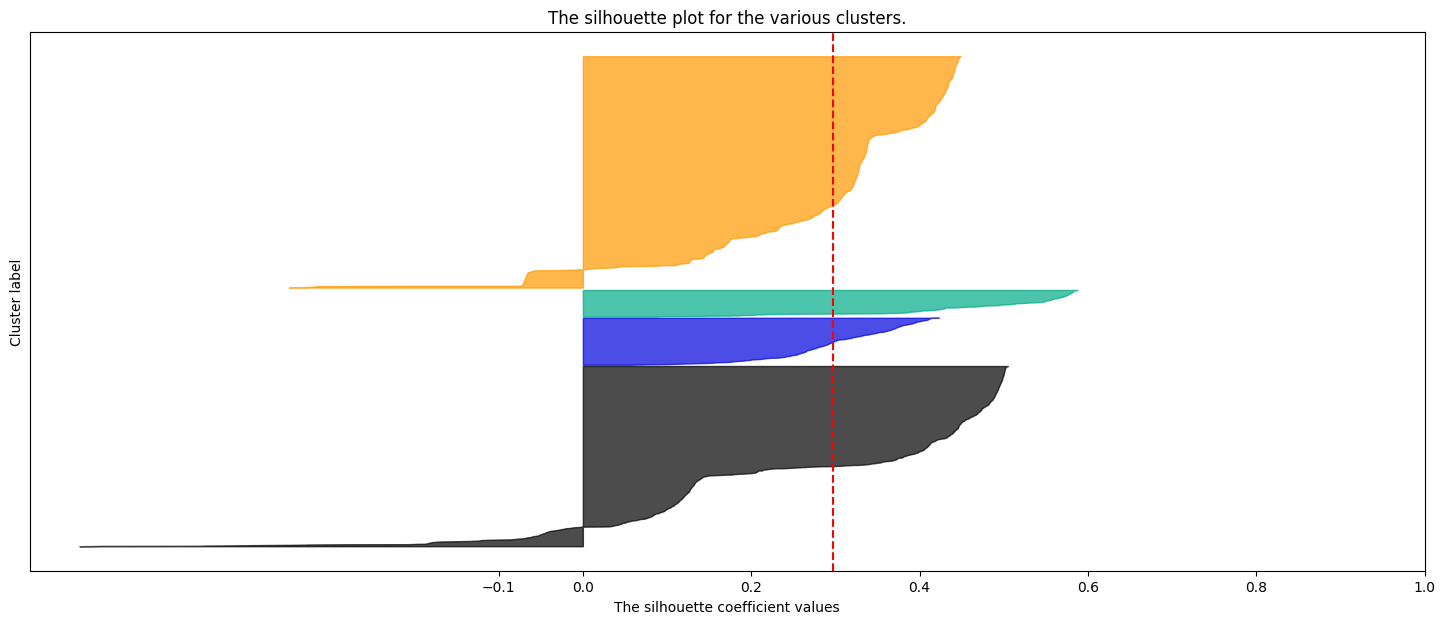

Silhouette Score for 6 clusters using average linkage: 0.3257778810019672


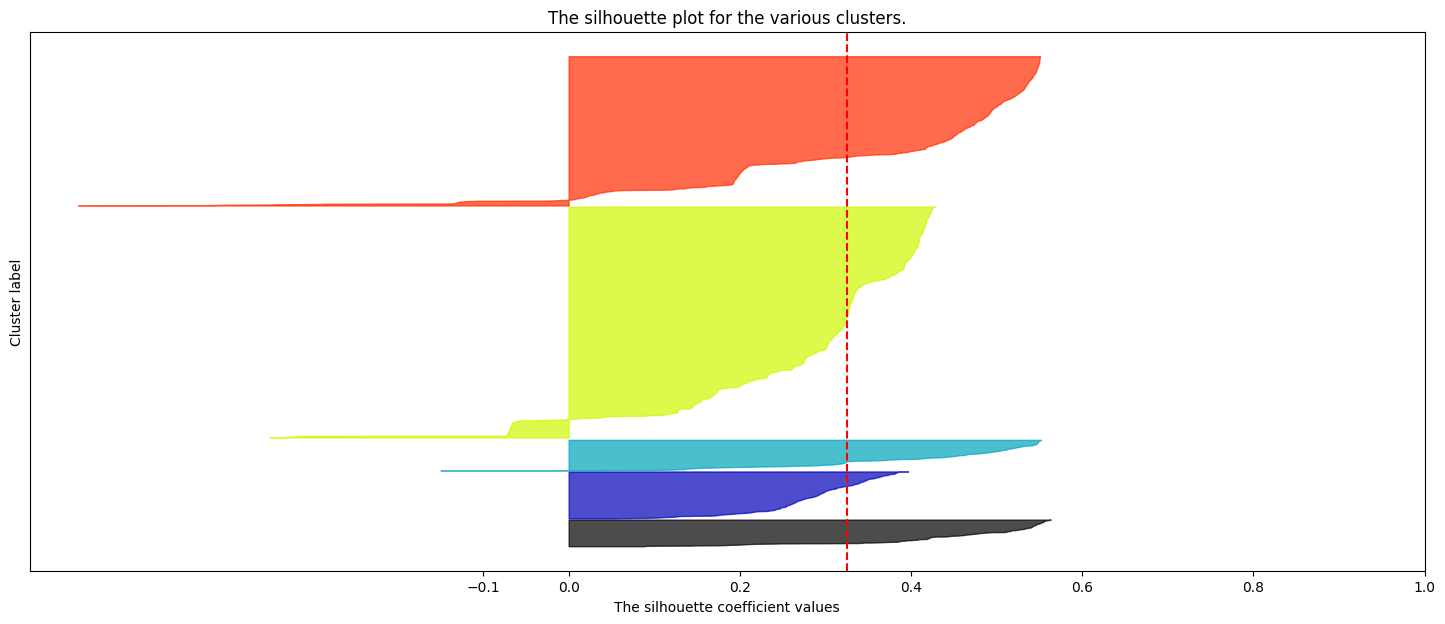

Silhouette Score for 7 clusters using average linkage: 0.3203519719309105


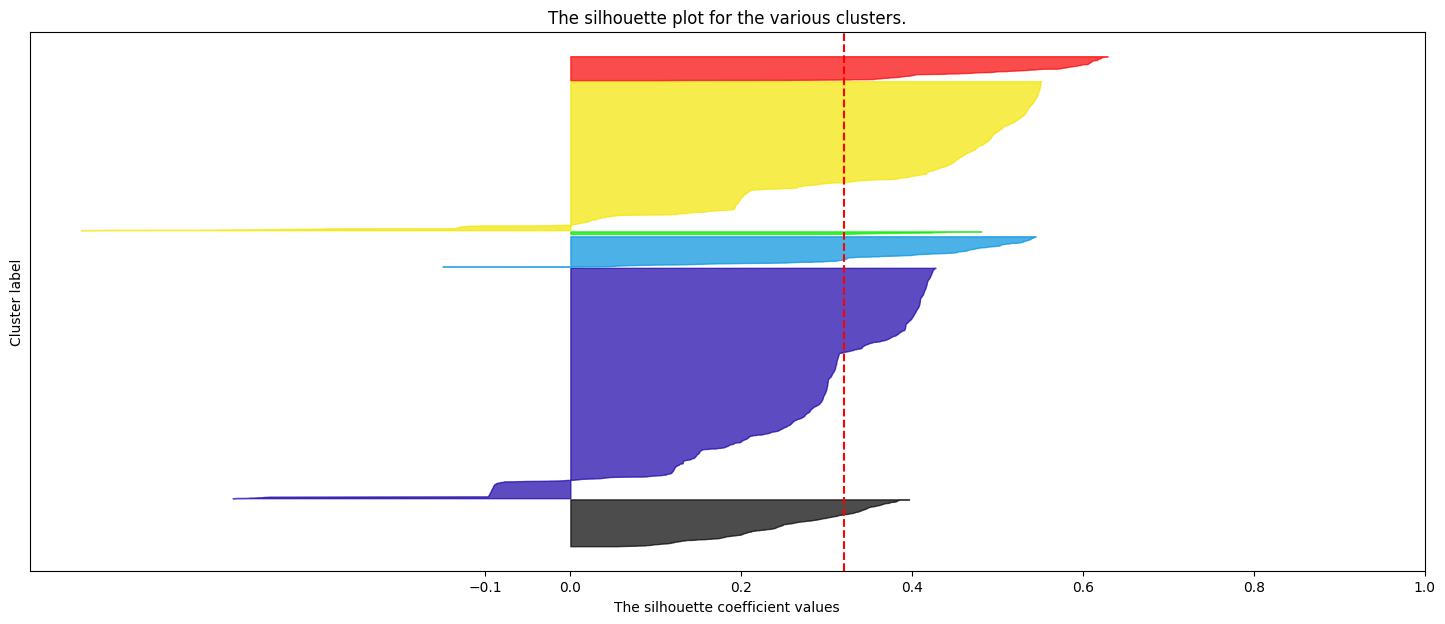

Silhouette Score for 8 clusters using average linkage: 0.33450386926831727


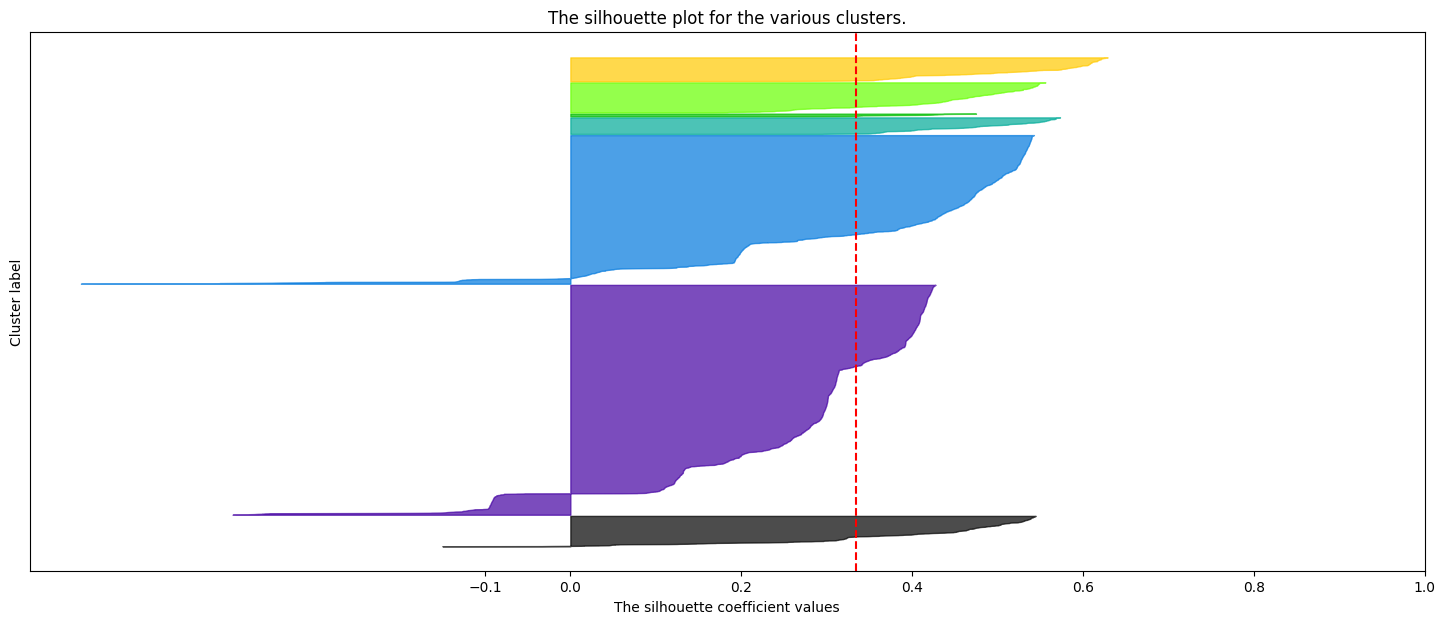

Silhouette Score for 9 clusters using average linkage: 0.3359476101650882


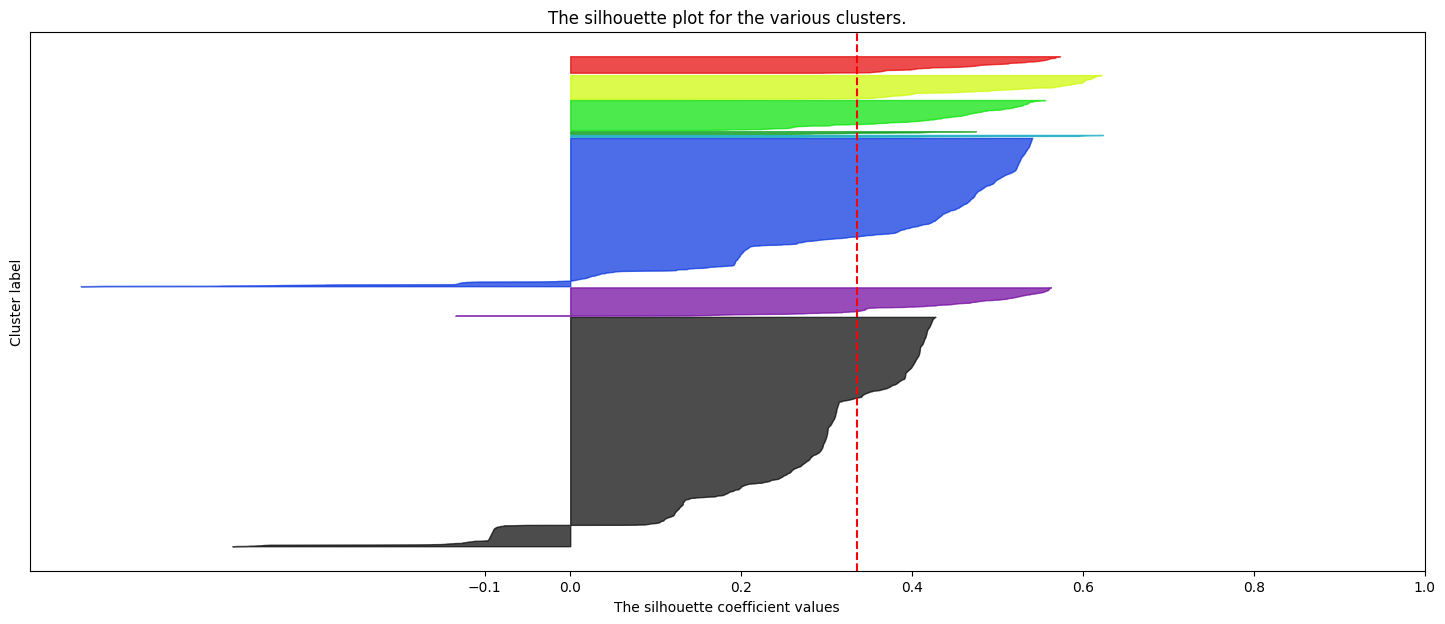

Silhouette Score for 10 clusters using average linkage: 0.4196411675754156


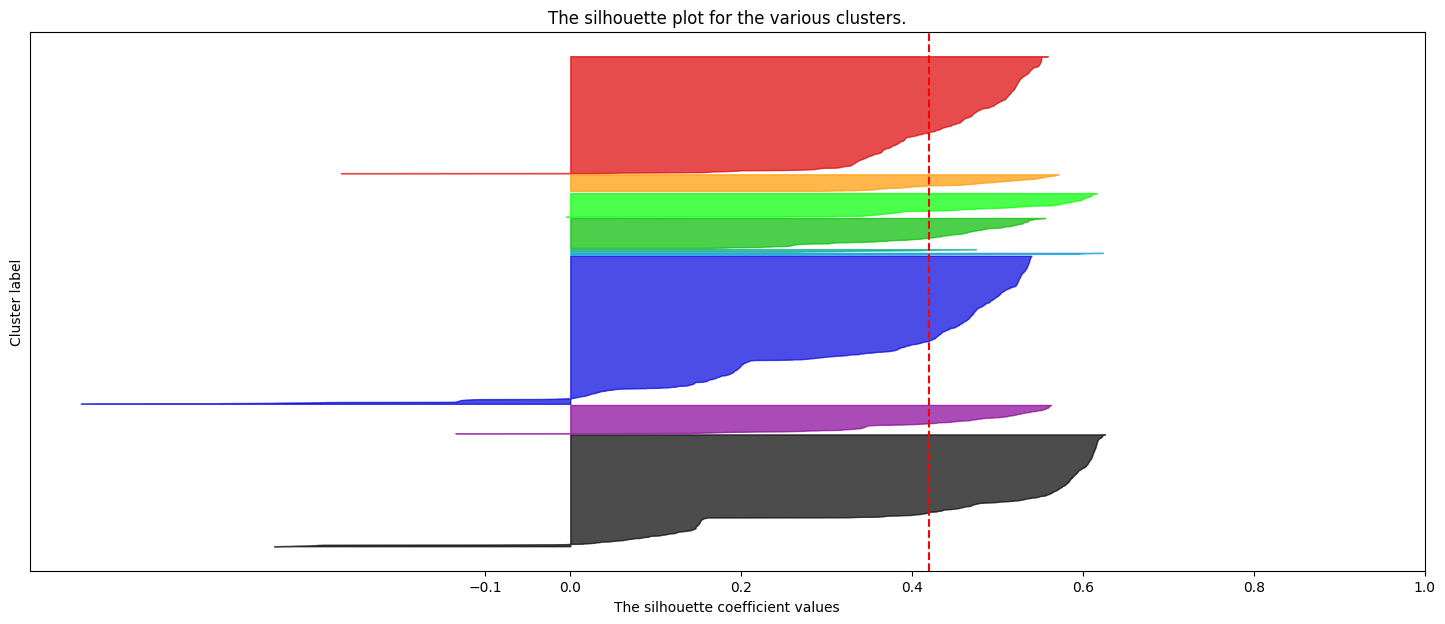

Silhouette Score for 11 clusters using average linkage: 0.4211172996822223


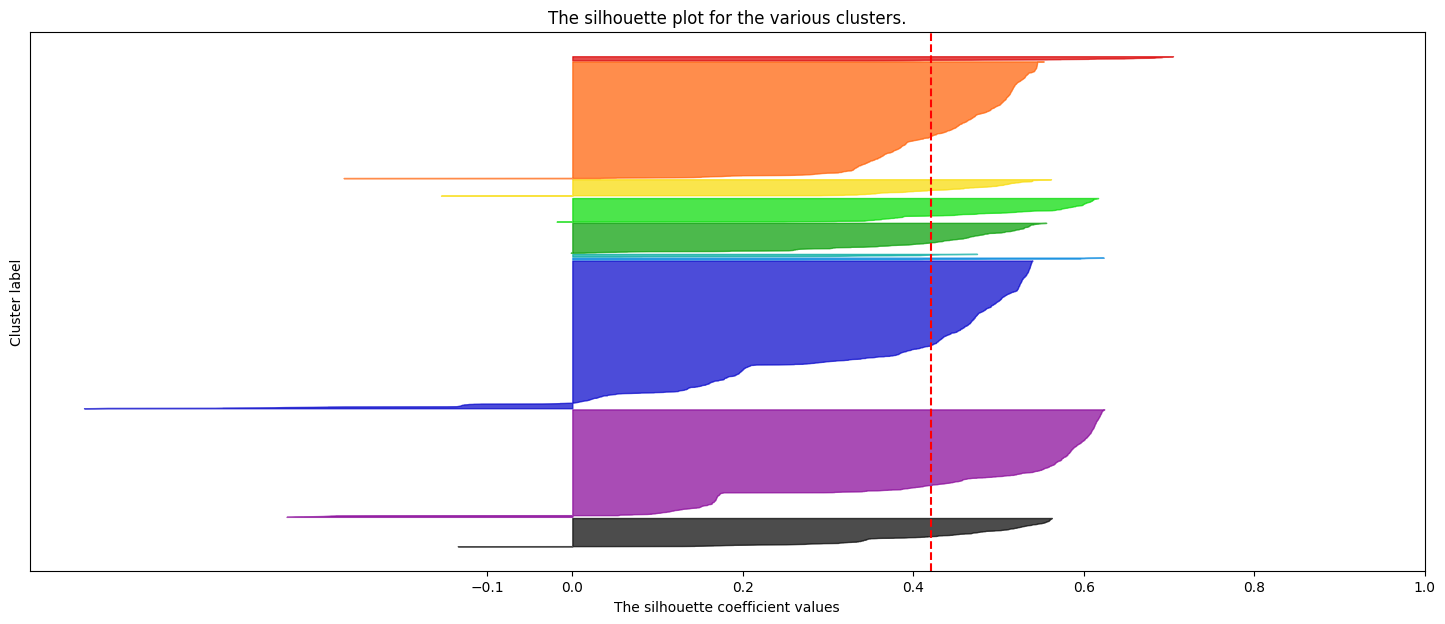

Silhouette Score for 12 clusters using average linkage: 0.418868842220035


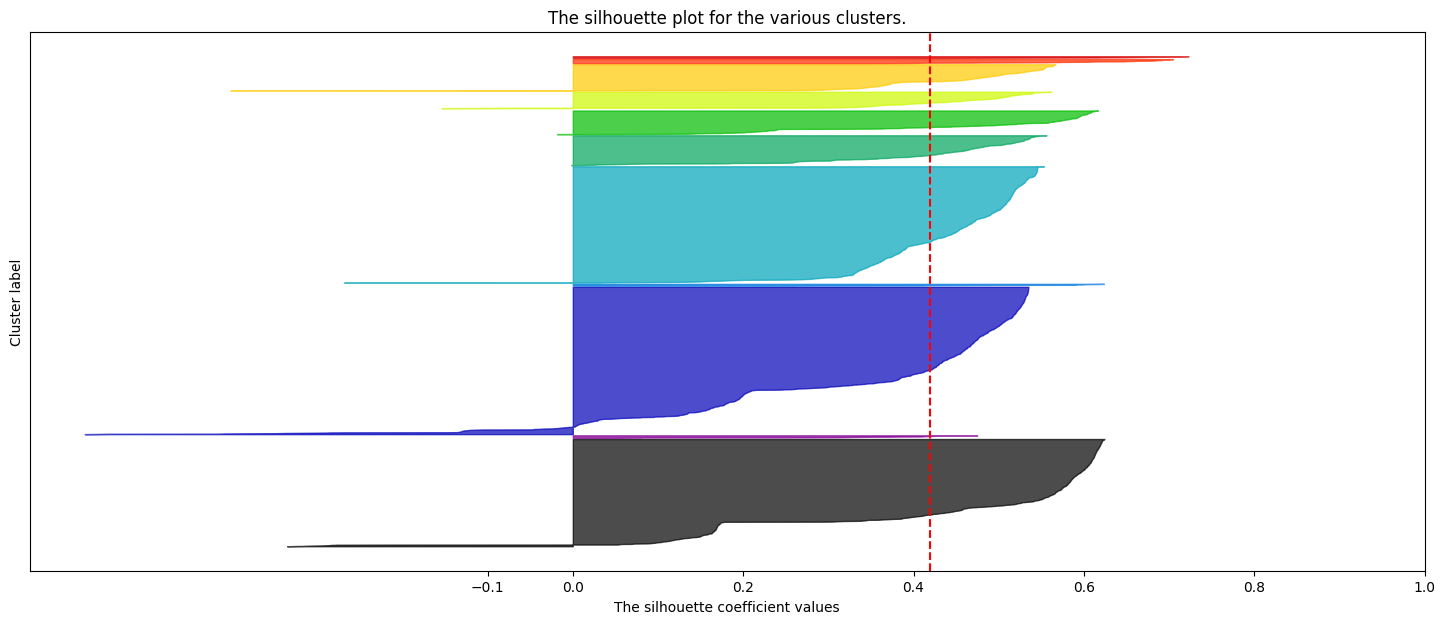

Silhouette Score for 13 clusters using average linkage: 0.44220314750878464


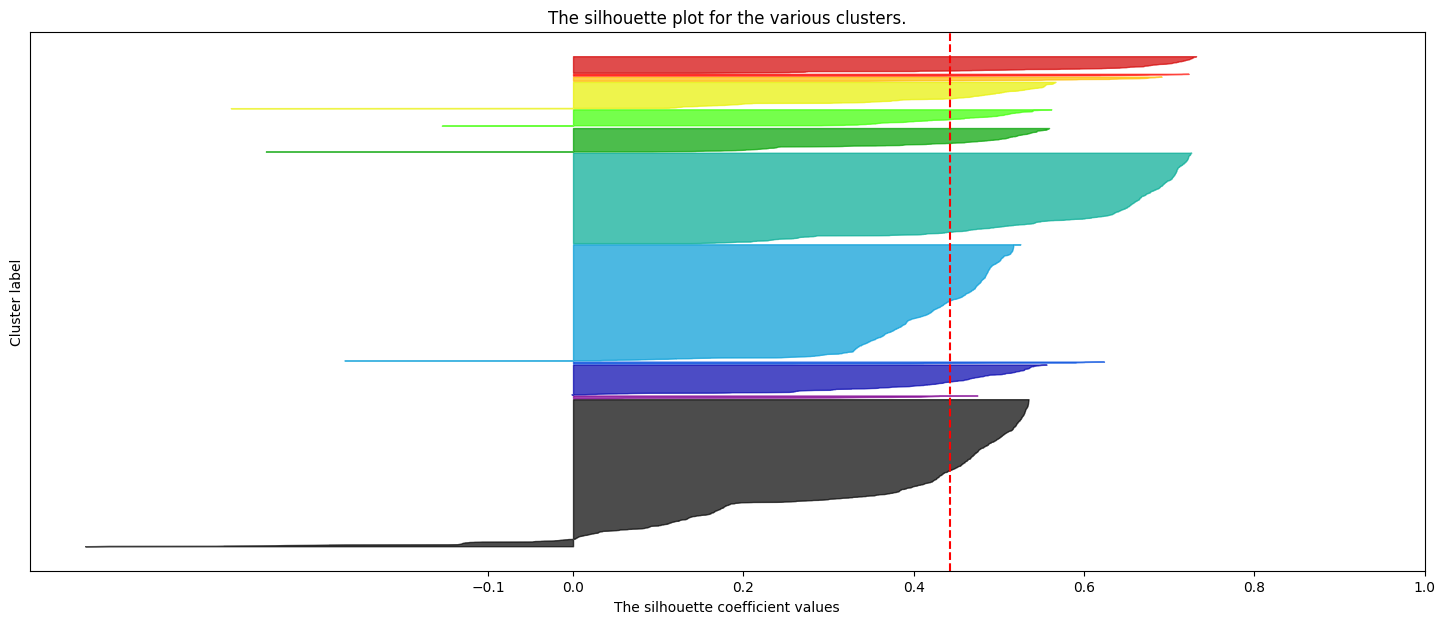

Silhouette Score for 14 clusters using average linkage: 0.4827580607521906


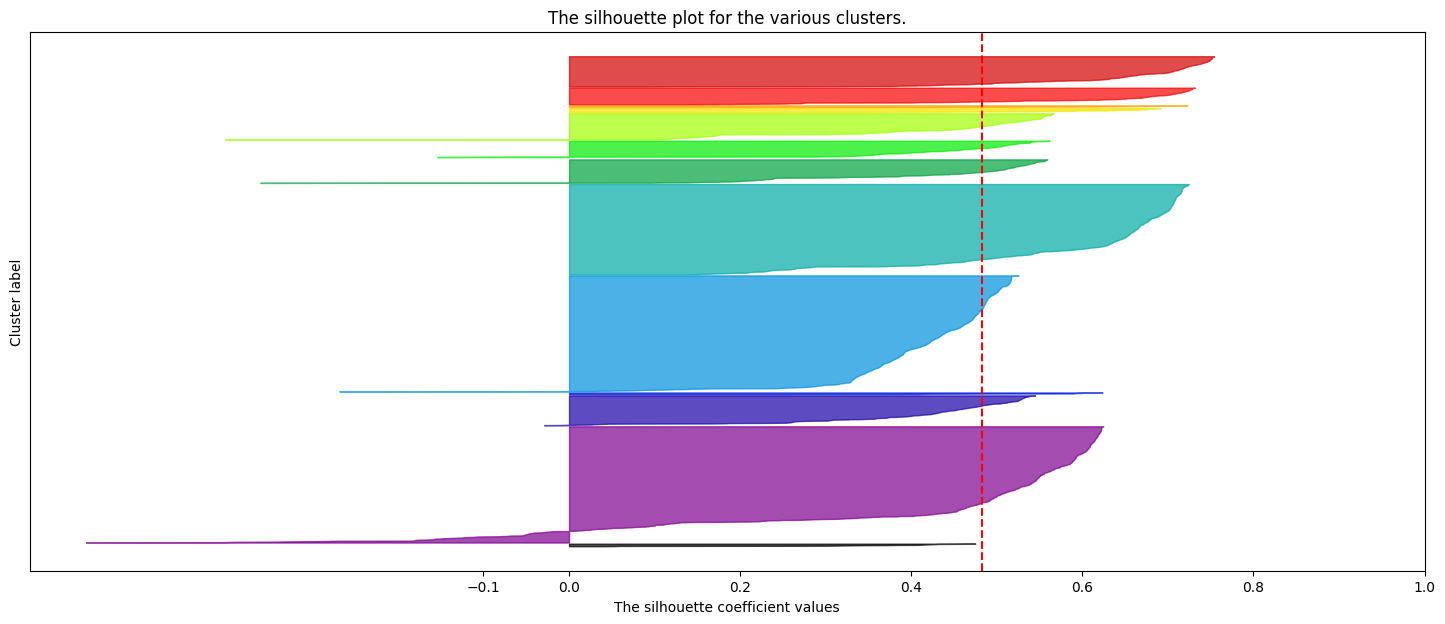

Silhouette Score for 15 clusters using average linkage: 0.482787849618785


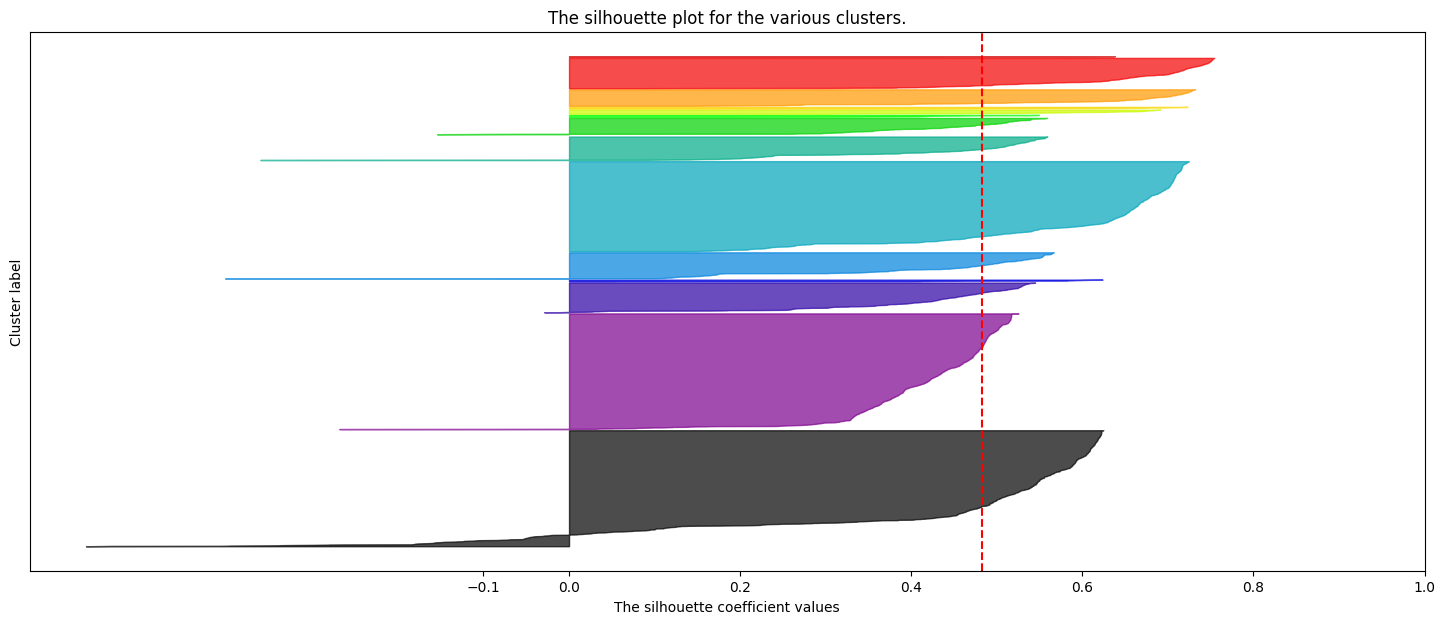

Inconsistency Coefficients for the last 10 cluster merges using ward:
[[ 2.0968068   2.90917733 31.          4.01482731]
 [ 2.20083442  3.07702098 31.          3.86060785]
 [ 3.43297718  3.15240972 31.          3.79314212]
 [ 3.29461274  3.95057764 31.          3.52447892]
 [ 2.76086504  3.85612797 31.          4.40723797]
 [ 3.41752009  4.45846756 31.          3.87958179]
 [ 6.36410399  6.34929033 31.          3.78946723]
 [ 4.18131551  6.31592614 31.          4.16952778]
 [ 7.18820181  8.15341628 31.          3.2806363 ]
 [12.01779864  9.97572083 31.          2.95750832]]
Unique clusters identified at cut depth using ward:
[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15]


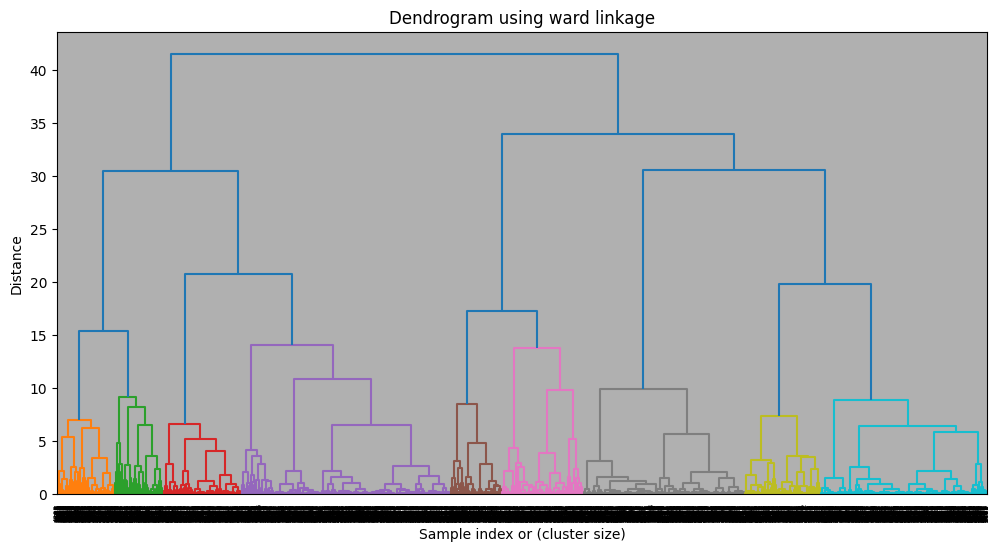

Silhouette Score for 2 clusters using ward linkage: 0.2567775902280189


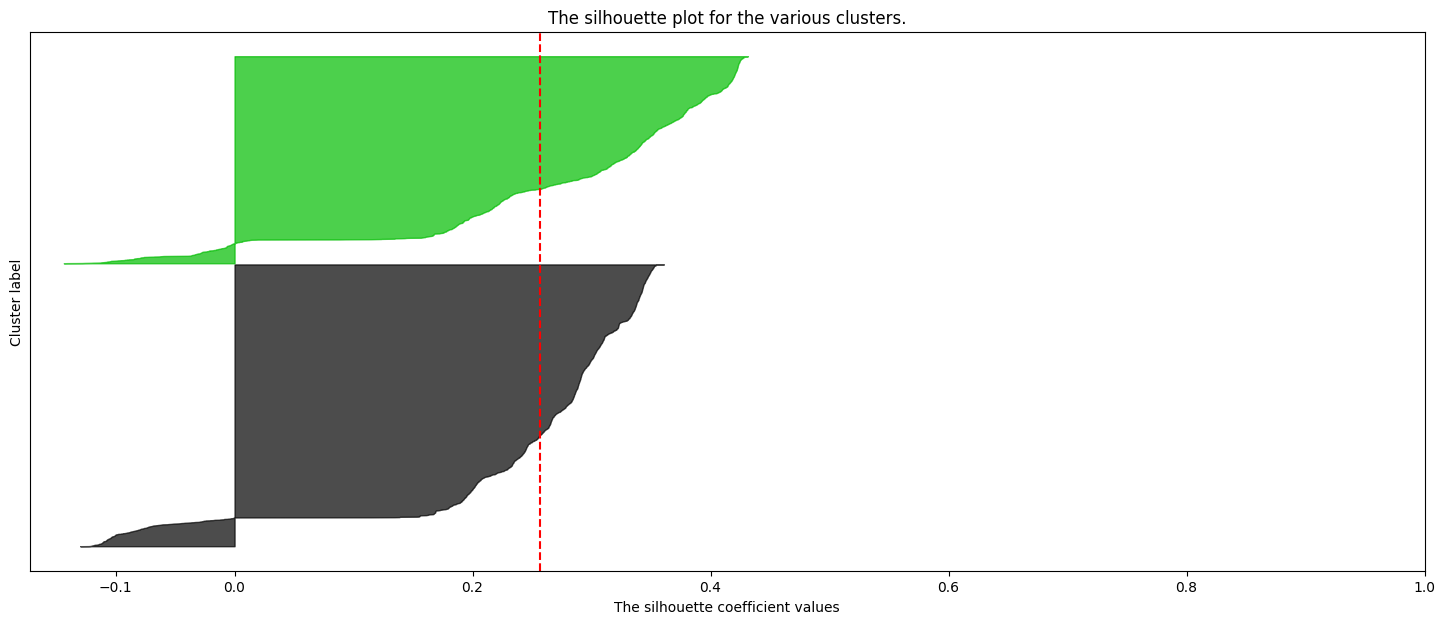

Silhouette Score for 3 clusters using ward linkage: 0.31127902004225433


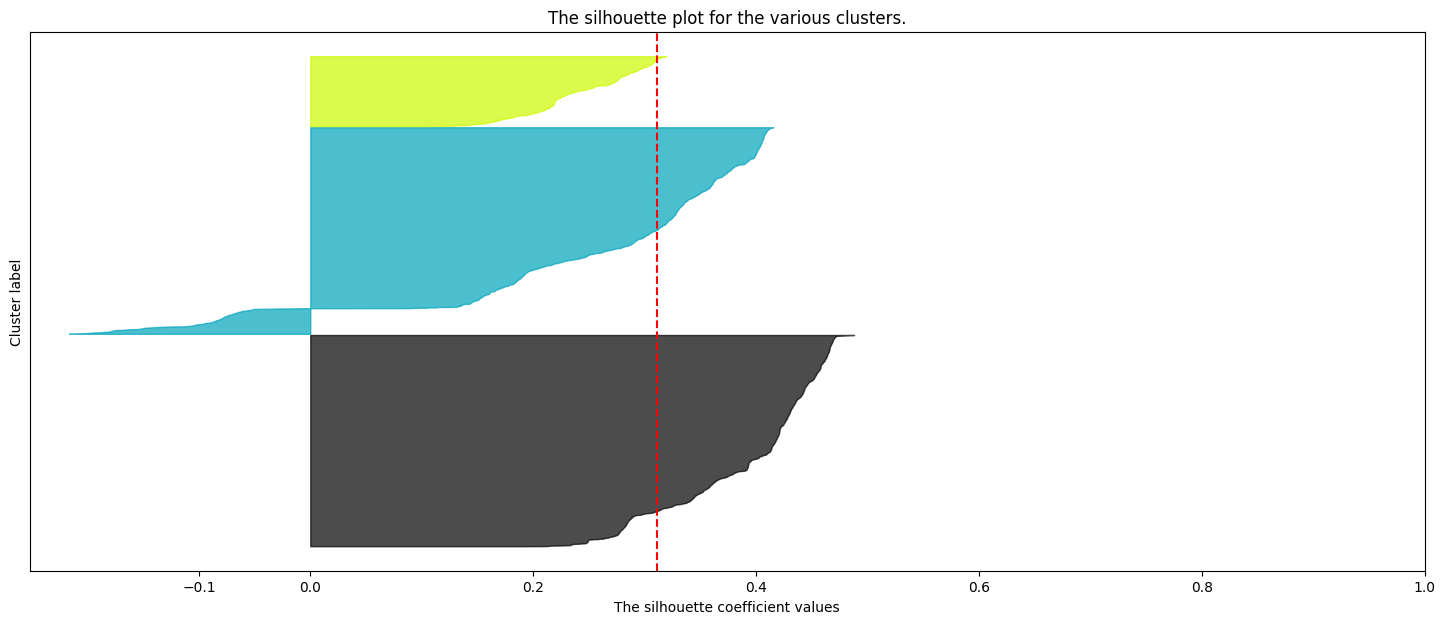

Silhouette Score for 4 clusters using ward linkage: 0.31970567173830905


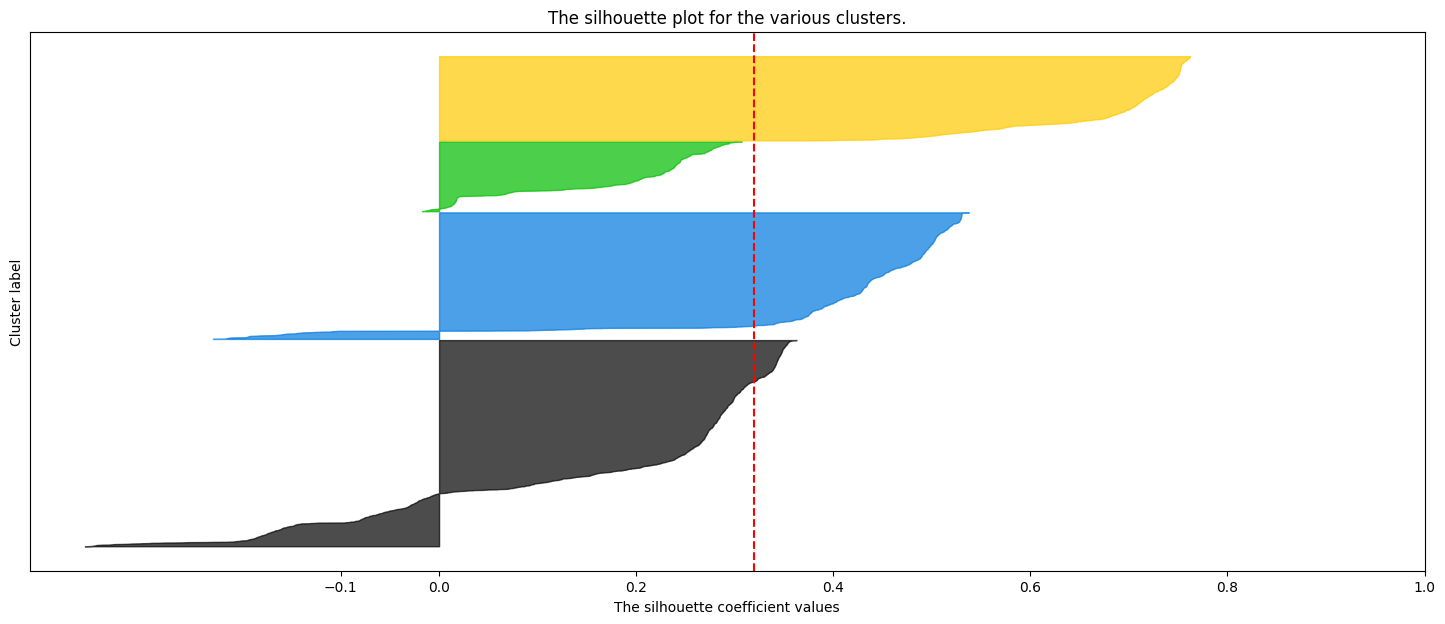

Silhouette Score for 5 clusters using ward linkage: 0.37949440022617464


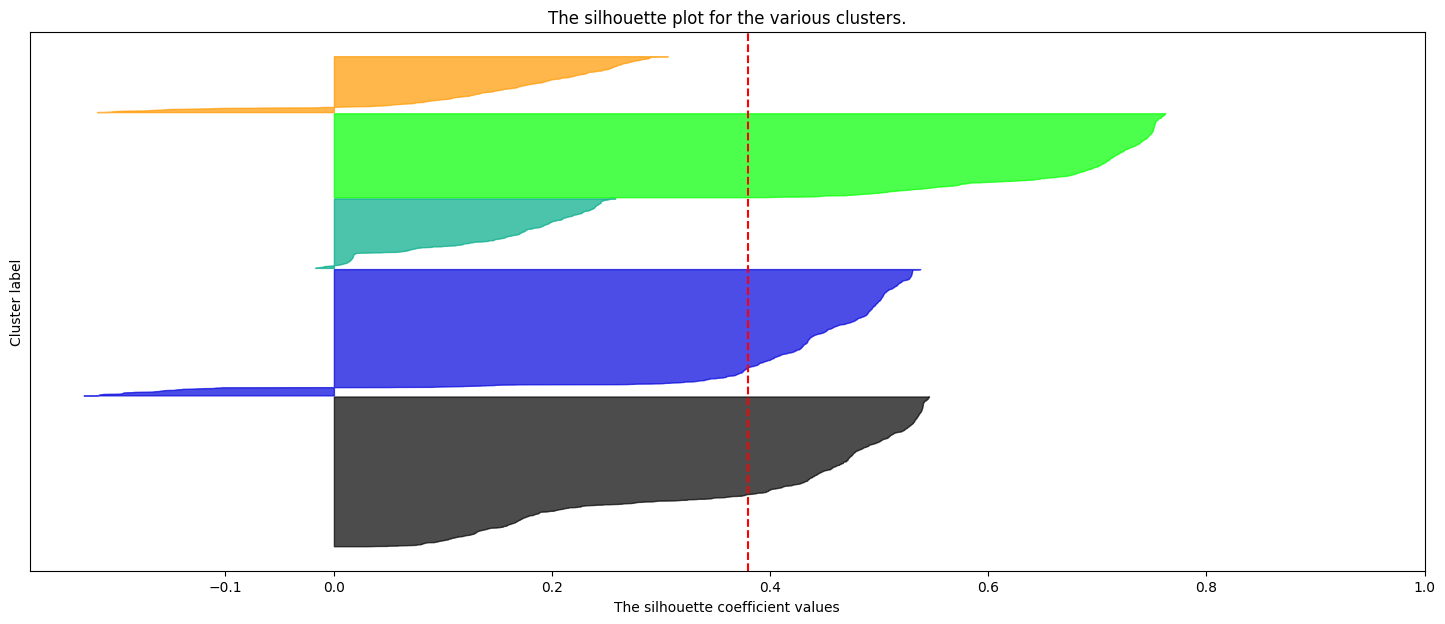

Silhouette Score for 6 clusters using ward linkage: 0.4006152695835695


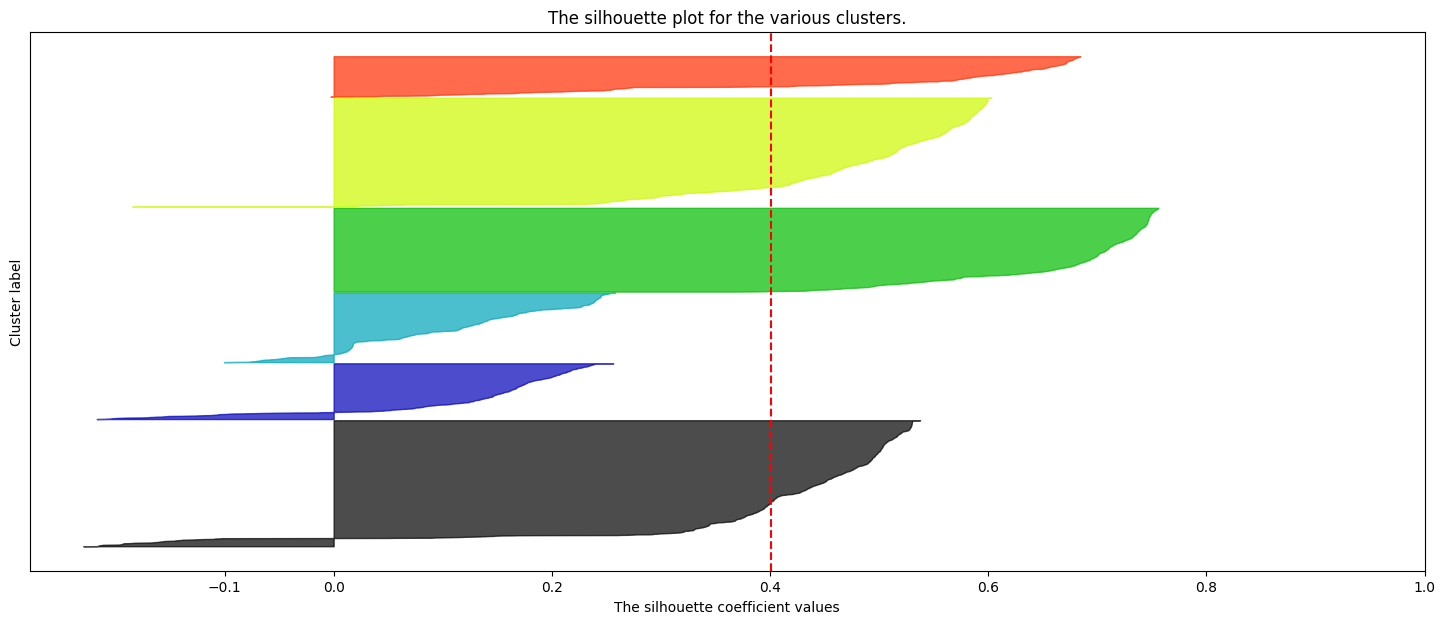

Silhouette Score for 7 clusters using ward linkage: 0.42036633560950604


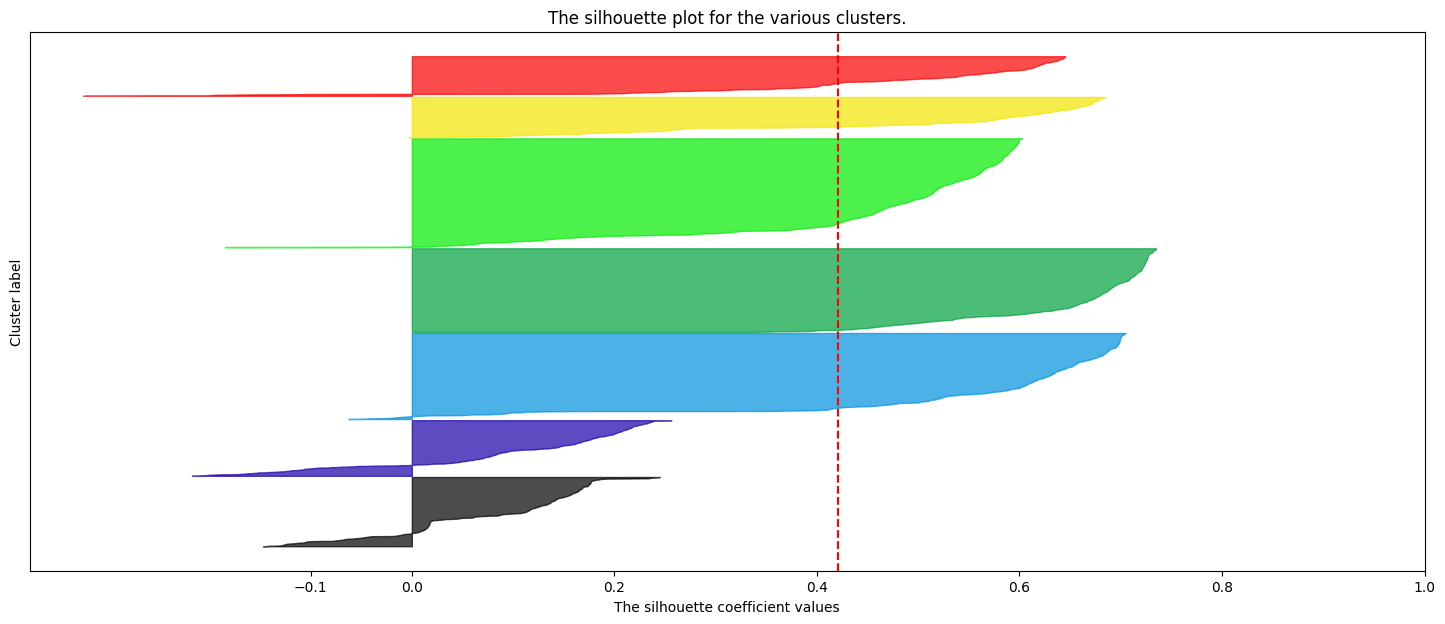

Silhouette Score for 8 clusters using ward linkage: 0.4511602234944311


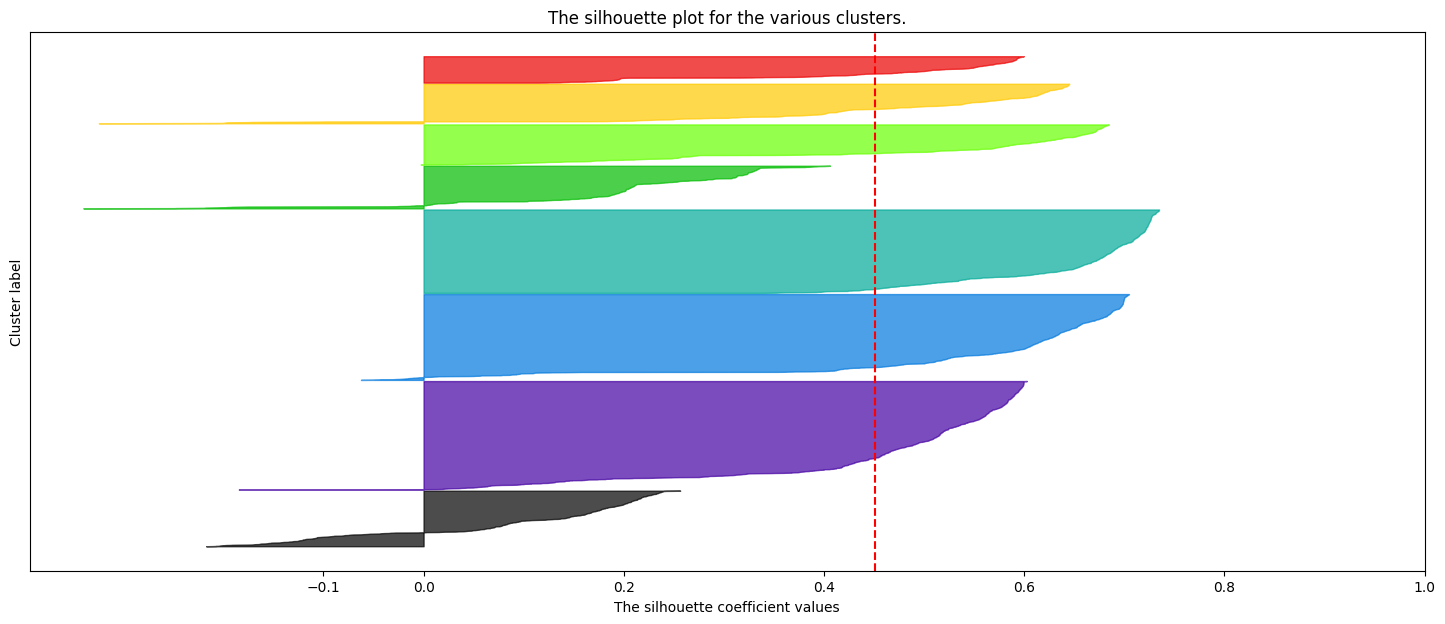

Silhouette Score for 9 clusters using ward linkage: 0.474294209033781


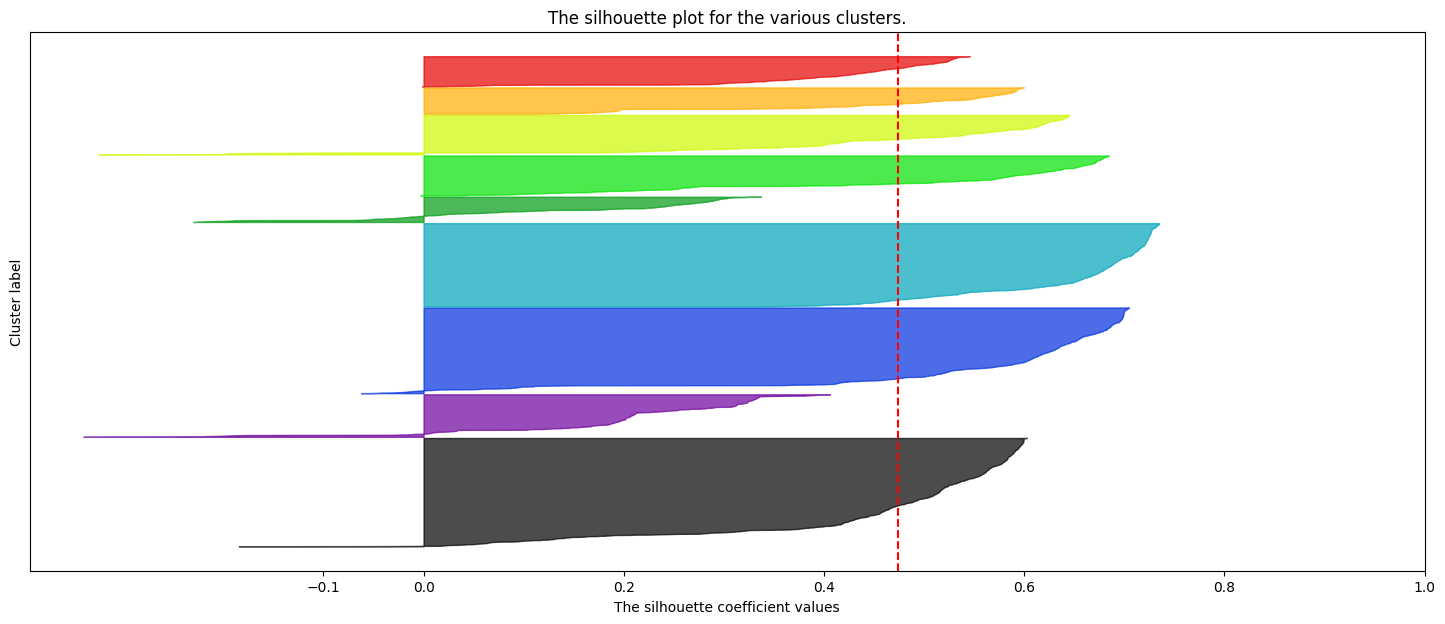

Silhouette Score for 10 clusters using ward linkage: 0.49504074394313674


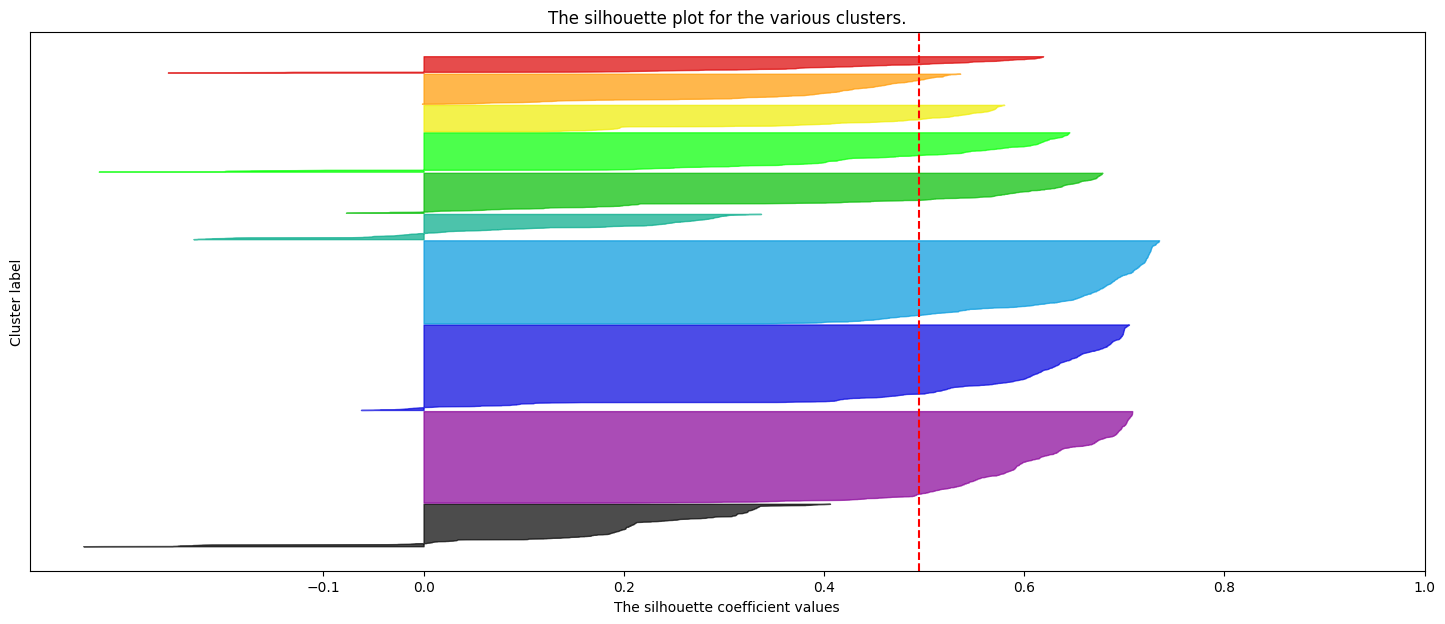

Silhouette Score for 11 clusters using ward linkage: 0.5164082613430556


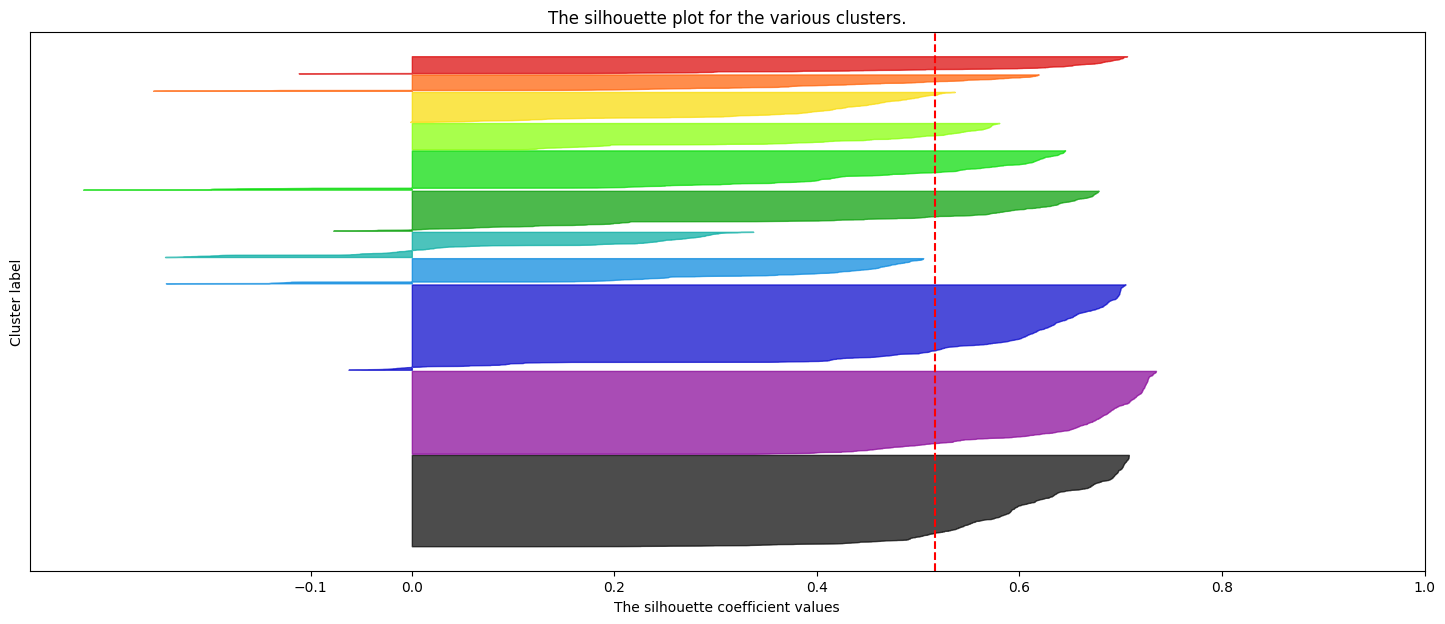

Silhouette Score for 12 clusters using ward linkage: 0.49902014314246035


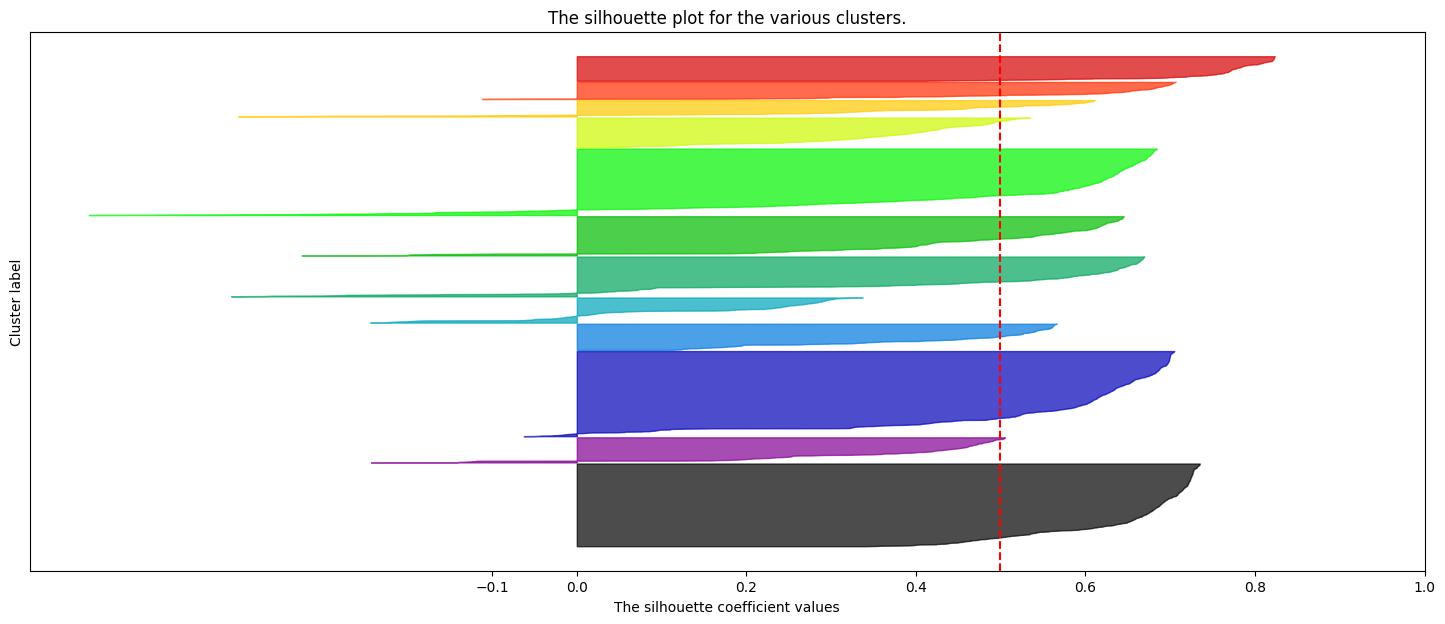

Silhouette Score for 13 clusters using ward linkage: 0.47549926638452406


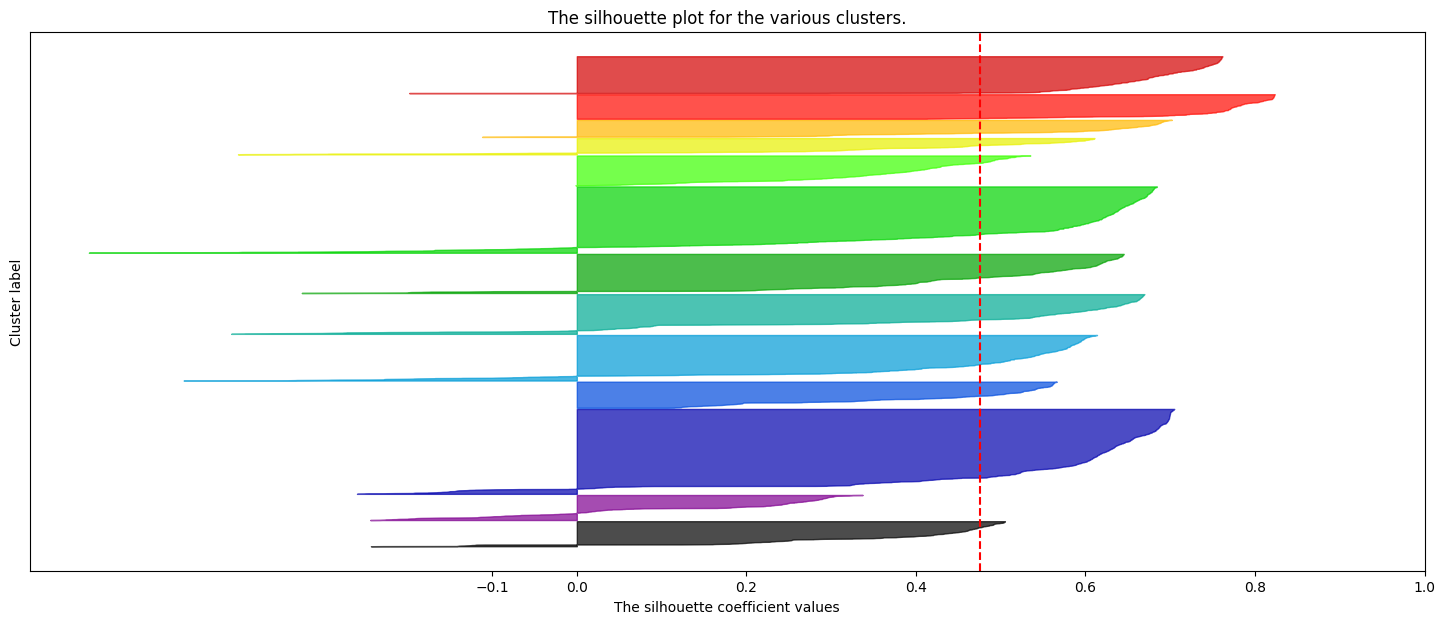

Silhouette Score for 14 clusters using ward linkage: 0.48639042218032047


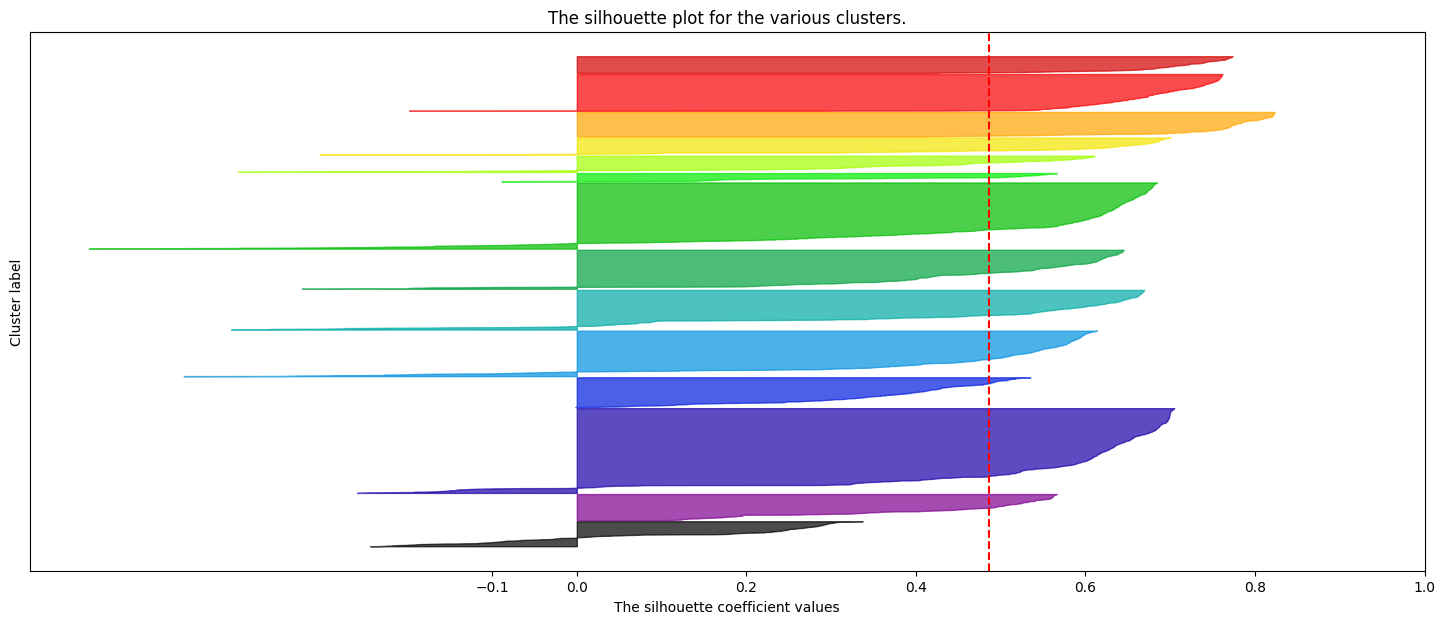

Silhouette Score for 15 clusters using ward linkage: 0.49346878900449886


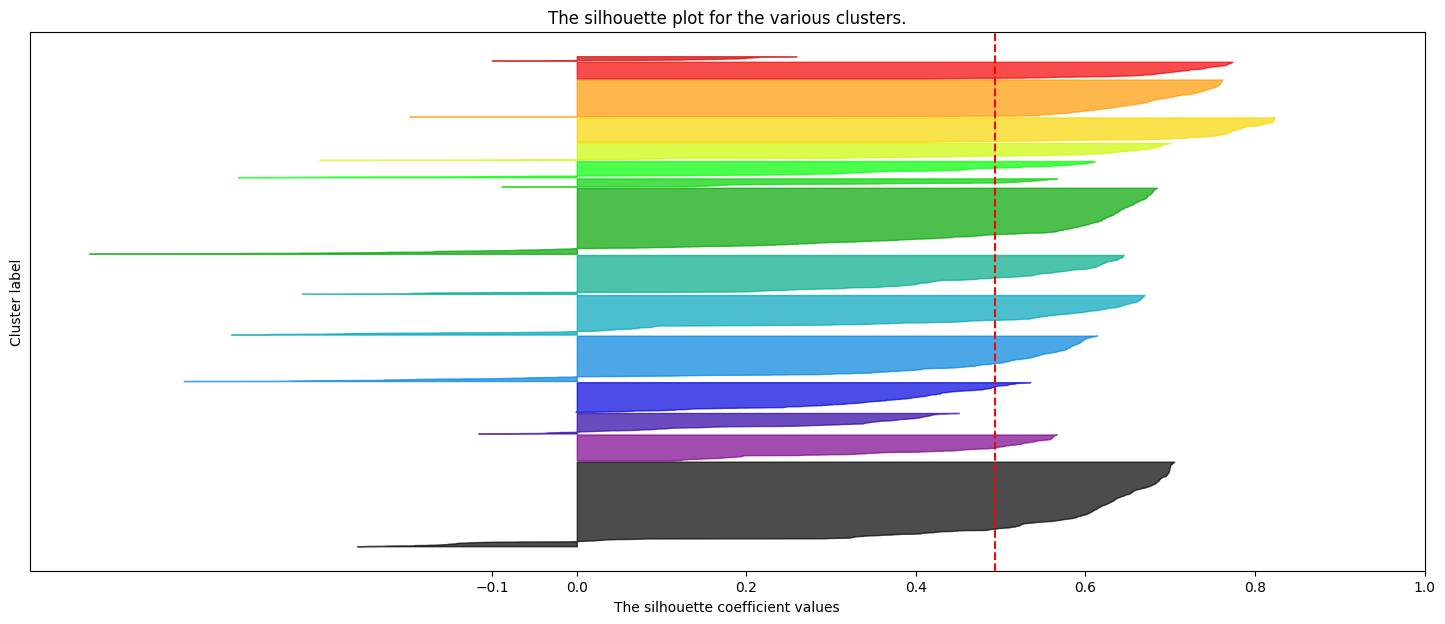

/var/folders/0q/1jlxr5dd7031jdc6z52plxzh0000gn/T/ipykernel_79143/3186979716.py:117: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


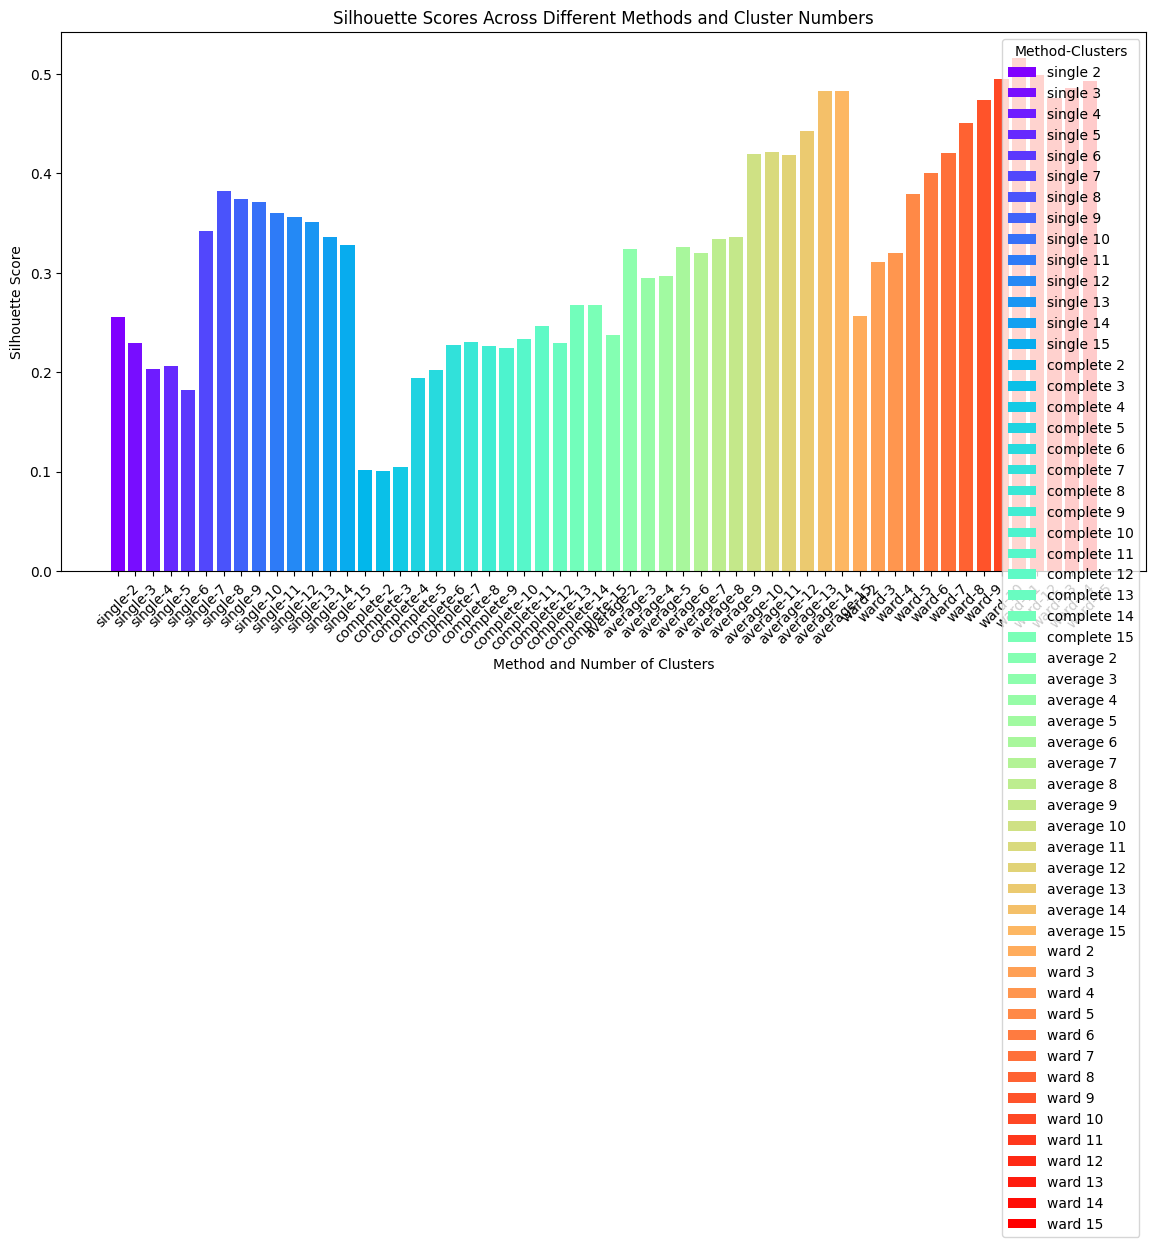

Best overall configuration: ward linkage with 11 clusters, Silhouette Score: 0.5164082613430556


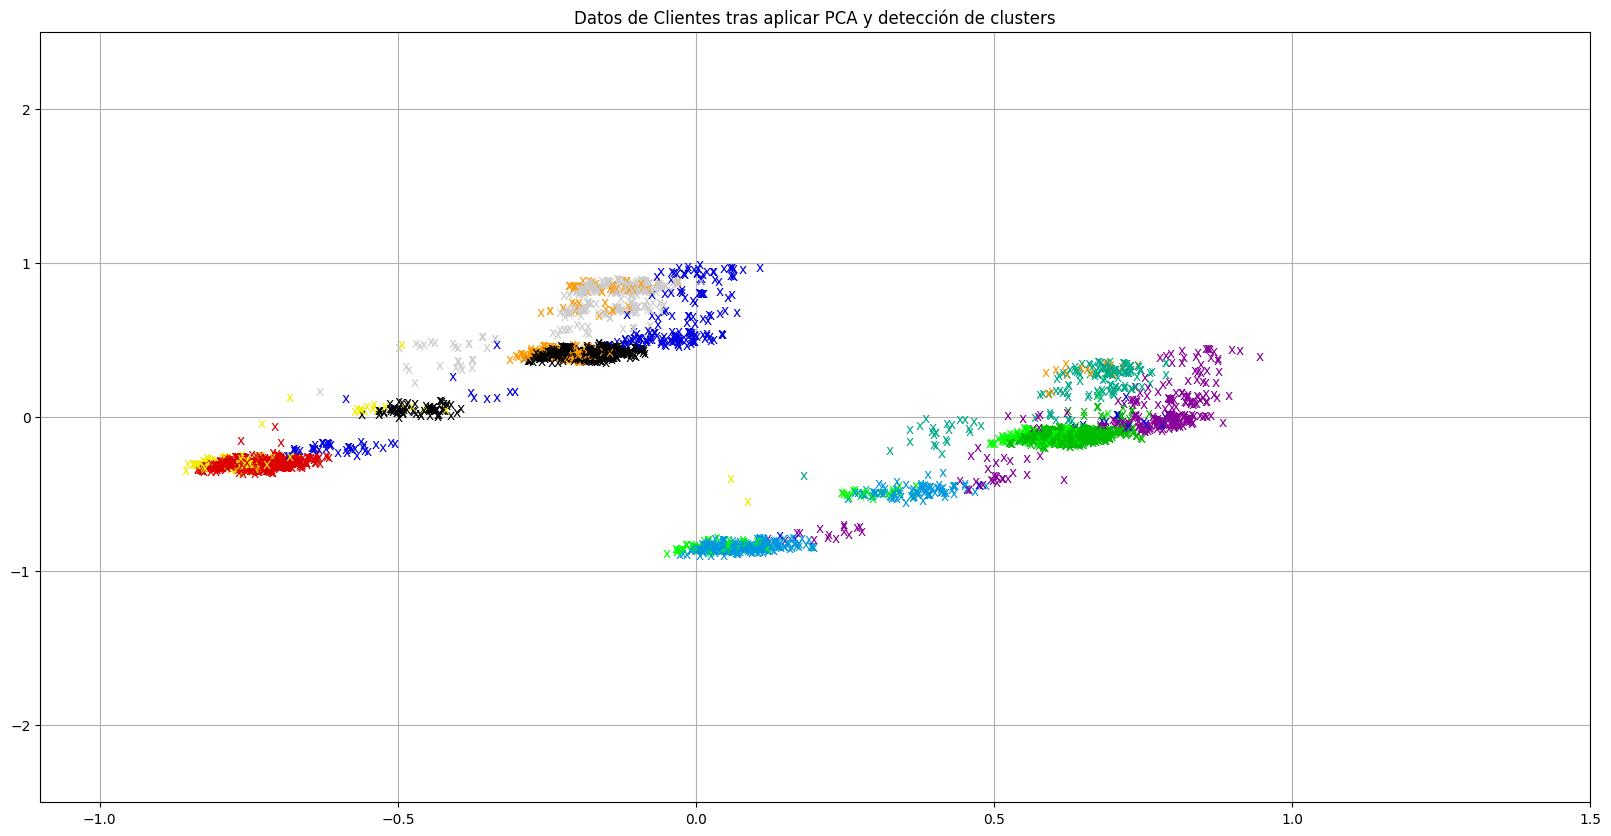

In [51]:
from scipy.cluster.hierarchy import linkage, inconsistent, fcluster, cophenet
from scipy.cluster import hierarchy
import sklearn.metrics
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.cm as cm 
from scipy.spatial.distance import pdist

dist = sklearn.metrics.DistanceMetric.get_metric('euclidean')
# Compute the distance matrix on PCA-transformed data
# By using pdist to create a condensed distance matrix from your PCA-transformed data,
# ensure that the linkage function receives the appropriate format.
D_pca_condensed = pdist(X_pca, 'euclidean')

avD_pca = np.average(D_pca_condensed)
print("Average Distance after PCA\t {:6.2f}".format(avD_pca))

# Assuming D_pca is your PCA-transformed data
methods = ['single', 'complete', 'average', 'ward']
best_scores = []
linkage_arrays = []  # To store linkage matrices for later use
silhouette_scores = []  # To store silhouette scores for comparison
silhouette_dict = {}  # Dictionary to store silhouette scores for each method and cluster count


# Process each linkage method
for method in methods:
    # Compute the hierarchical clustering and store the linkage matrix
    linkage_matrix = linkage(D_pca_condensed, method=method)
    linkage_arrays.append(linkage_matrix)

    # Use the inconsistency coefficient to help decide where to cut the dendrogram
    depth = 5
    incons = inconsistent(linkage_matrix, depth)
    print(f"Inconsistency Coefficients for the last 10 cluster merges using {method}:")
    print(incons[-10:])
    
    # Determine clusters by cutting the dendrogram at a chosen depth
    max_d = 15
    clusters_cut = fcluster(linkage_matrix, max_d, criterion='maxclust')
    print(f"Unique clusters identified at cut depth using {method}:")
    print(np.unique(clusters_cut))

    # Visualize the dendrogram for this linkage method
    plt.figure(figsize=(12, 6))
    dendrogram = hierarchy.dendrogram(linkage_matrix, color_threshold=15)
    plt.title(f"Dendrogram using {method} linkage")
    plt.xlabel("Sample index or (cluster size)")
    plt.ylabel("Distance")
    plt.grid(True)
    plt.show()

    # Analyze clusters from 2 to a reasonable upper limit based on the dendrogram
    for num_clusters in np.unique(clusters_cut):
        if num_clusters > 1:  # Silhouette score requires at least 2 clusters

            agglom_clustering = AgglomerativeClustering(n_clusters=num_clusters, linkage=method)
            labels = agglom_clustering.fit_predict(X_pca)
            
            # Calculate the silhouette score
            silhouette_avg = silhouette_score(X_pca, labels)
            silhouette_dict[(method, num_clusters)] = silhouette_avg
            print(f"Silhouette Score for {num_clusters} clusters using {method} linkage: {silhouette_avg}")

            # Plot the silhouette score for each sample
            fig, ax1 = plt.subplots(1, 1)
            fig.set_size_inches(18, 7)

            # Compute the silhouette scores for each sample
            sample_silhouette_values = silhouette_samples(X_pca, labels)

            y_lower = 10
            for i in range(num_clusters):
                # Aggregate the silhouette scores for samples belonging to cluster i, and sort them
                ith_cluster_silhouette_values = sample_silhouette_values[labels == i]
                ith_cluster_silhouette_values.sort()

                size_cluster_i = len(ith_cluster_silhouette_values)
                y_upper = y_lower + size_cluster_i

                color = cm.nipy_spectral(float(i) / num_clusters)
                ax1.fill_betweenx(np.arange(y_lower, y_upper), 0, ith_cluster_silhouette_values,
                                facecolor=color, edgecolor=color, alpha=0.7)

                y_lower = y_upper + 10  # 10 for the 0 samples gap between clusters

            ax1.set_title("The silhouette plot for the various clusters.")
            ax1.set_xlabel("The silhouette coefficient values")
            ax1.set_ylabel("Cluster label")

            ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

            ax1.set_yticks([])  # Clear the yaxis labels / ticks
            ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

            plt.show()          

            # Store the best score along with method and cluster count for comparison
            best_scores.append((silhouette_avg, num_clusters, method))

# Select the best overall clustering based on the silhouette score
best_overall = max(best_scores, key=lambda x: x[0])

# Plotting all silhouette scores
plt.figure(figsize=(14, 7))
colors = cm.rainbow(np.linspace(0, 1, len(silhouette_dict)))
for ((method, num_clusters), silhouette_avg), color in zip(silhouette_dict.items(), colors):
    plt.bar(f'{method}-{num_clusters}', silhouette_avg, color=color, label=f'{method} {num_clusters}')

plt.title('Silhouette Scores Across Different Methods and Cluster Numbers')
plt.xlabel('Method and Number of Clusters')
plt.ylabel('Silhouette Score')
plt.xticks(rotation=45)
plt.legend(title='Method-Clusters')
plt.tight_layout()
plt.show()
print(f"Best overall configuration: {best_overall[2]} linkage with {best_overall[1]} clusters, Silhouette Score: {best_overall[0]}")

# Choose the best configuration based on silhouette score
best_config = max(silhouette_dict, key=silhouette_dict.get)
best_method, best_clusters = best_config
final_labels = fcluster(linkage(X_pca, method=best_method), best_clusters, criterion='maxclust')

# Plotting the PCA-transformed data with cluster labels
plt.figure(figsize=(20, 10))
color_palette = cm.nipy_spectral(np.linspace(0, 1, best_clusters))
for i in range(len(X_pca)):
    plt.text(X_pca[i][0], X_pca[i][1], 'x', color=color_palette[final_labels[i] % len(color_palette)])  # Using modulo to avoid index out of bounds

plt.xlim(-1.1, 1.5)
plt.ylim(-2.5, 2.5)
plt.grid(True)
plt.title("Datos de Clientes tras aplicar PCA y detección de clusters")
plt.show()

# Export data to excel

In [52]:

transformed_df['Cluster'] = clusters_cut
transformed_df.to_excel('datos.xlsx', index=False, engine='openpyxl')

# DBSCAN

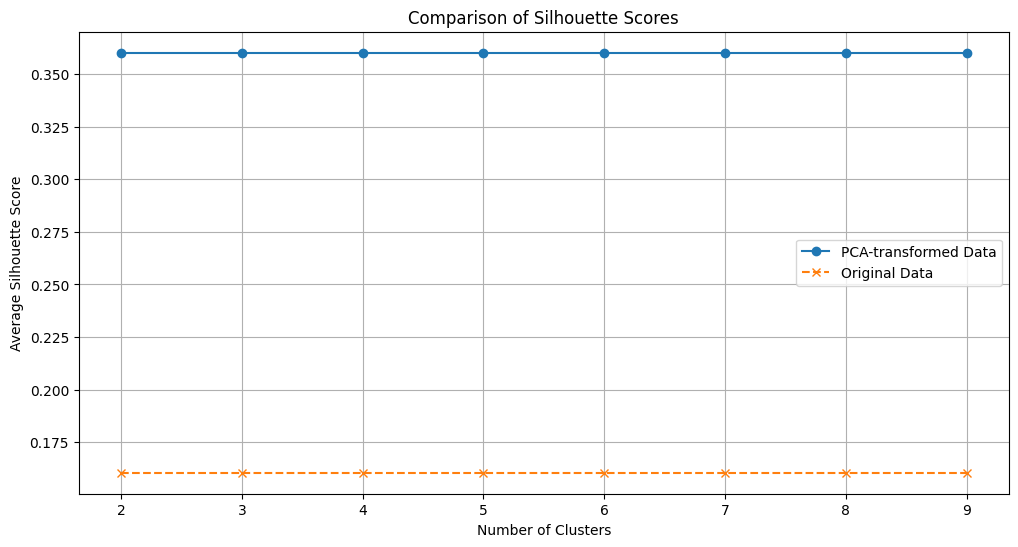

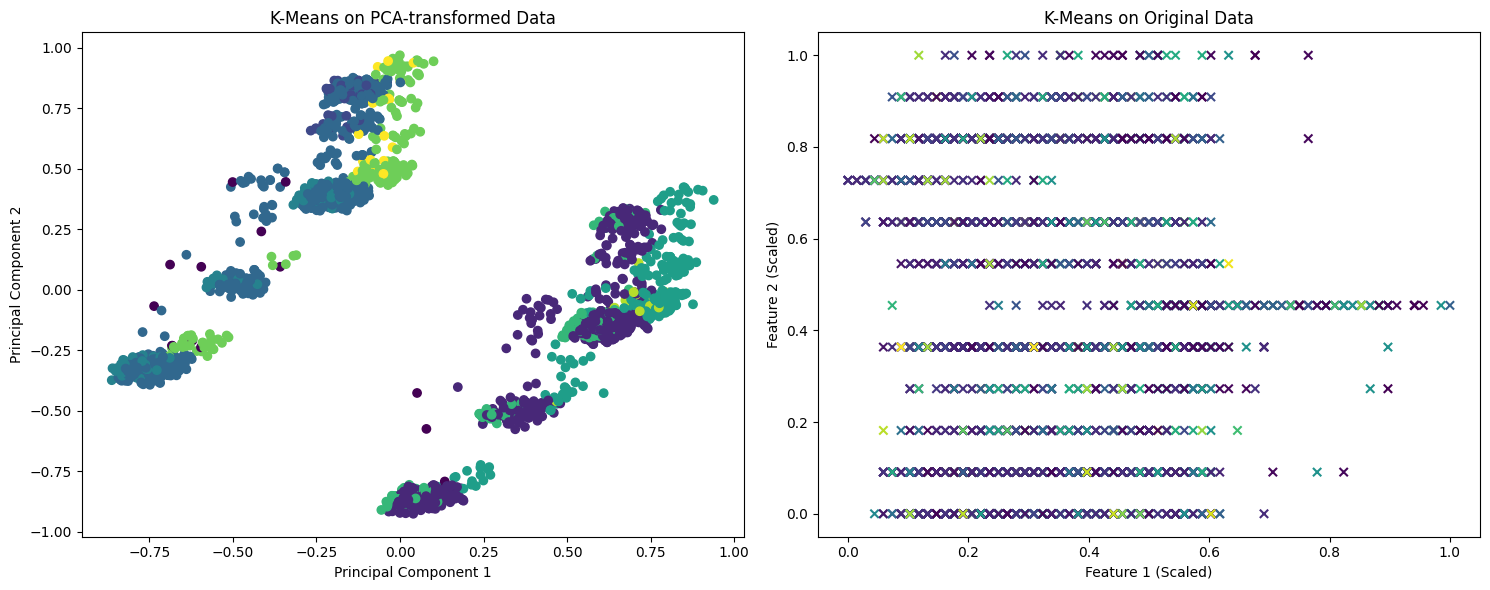

In [53]:
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import numpy as np

# Transformed_data is your preprocessed data ready for clustering
# and X_pca is the PCA-transformed data

# Define the range of clusters to evaluate
range_n_clusters = list(range(2, 10))
silhouette_avg_pca = []
silhouette_avg_original = []

for n_clusters in range_n_clusters:
    clusterer = DBSCAN(eps=0.5, min_samples=5)
    cluster_labels_pca = clusterer.fit_predict(transformed_df.drop(columns='y'))
    # Clustering on PCA-transformed data
    cluster_labels_pca = clusterer.fit_predict(X_pca)
    silhouette_avg_pca.append(silhouette_score(X_pca, cluster_labels_pca))
    
    # Clustering on original data
    cluster_labels_original = clusterer.fit_predict(transformed_data)
    silhouette_avg_original.append(silhouette_score(transformed_data, cluster_labels_original))

# Plotting the silhouette scores
plt.figure(figsize=(12, 6))
plt.plot(range_n_clusters, silhouette_avg_pca, marker='o', linestyle='-', label='PCA-transformed Data')
plt.plot(range_n_clusters, silhouette_avg_original, marker='x', linestyle='--', label='Original Data')
plt.title('Comparison of Silhouette Scores')
plt.xlabel('Number of Clusters')
plt.ylabel('Average Silhouette Score')
plt.legend()
plt.grid(True)
plt.show()
fig, ax = plt.subplots(1, 2, figsize=(15, 6))

# Visualization on PCA-transformed data
ax[0].scatter(X_pca[:, 0], X_pca[:, 1], c=cluster_labels_pca, cmap='viridis', marker='o')
ax[0].set_title("K-Means on PCA-transformed Data")
ax[0].set_xlabel("Principal Component 1")
ax[0].set_ylabel("Principal Component 2")

# Visualization on original data (if it's 2D or has been reduced for visualization)
ax[1].scatter(transformed_data[:, 0], transformed_data[:, 1], c=cluster_labels_original, cmap='viridis', marker='x')
ax[1].set_title("K-Means on Original Data")
ax[1].set_xlabel("Feature 1 (Scaled)")
ax[1].set_ylabel("Feature 2 (Scaled)")

plt.tight_layout()
plt.show()